Описание данных
wellName Название скважины

datasetName Название набора данных

MD Измеренная глубина

BK Боковой каротаж (сопротивление)

Facies Фация (свойство)

GR Гамма-каротаж

LIT Литология

NKTB Нейтронный каротаж

SP Метод потенциалов собственной поляризации

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и плотных породах на большом интервале

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и коллекторах на большом интервале

Нужно определять фации в коллеторах (LIT = 4)

1 – глина

2 – алевролит

5- плотная порода

6 - уголь

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и плотных породах на большом интервале

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и коллекторах на большом интервале, но не выше 2000 м (MD>2000)

Самые основные конечно – GR и SP, их форму геологи учитывают для определения условий осадконакопления, можно будет попробовать оценить форму кривых, а не значения параметра) Единственный нюанс – пока в таблице всего 19 скважин, но фации в них выделены наиболее уверенно. Ну и судя по всему, информация с MD < 2000 не принципиальна

SP (каротаж естественной поляризации)
GR (гамма каротаж)
DT (акустический каротаж)
Density (плотностной каротаж)

In [35]:
# Загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import random as rd
import seaborn as sns
import lasio
from os import listdir
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from IPython.display import display, clear_output
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

In [63]:
def get_well_dfs(all_well_df):
    wall_names_ = all_well_df['wellName'].unique()
    wells = []
    for name in wall_names_:
        well = all_well_df[all_well_df['wellName'] == name]
        wells.append(well)
    return wells


def add_wells_features(wells, features_for_detrend):
    wells_new = []
    for well in wells:
        wells_new.append(detrend(well, features_for_detrend))
    return wells_new


def detrend(df, features_for_detrend):
    undefined_value = -9999

    def check_correct_md(df_):
        def is_md_correct(row, md, md_last):
            difference = row[md_last] - row[md]
            if (difference - 0.2) > 0.001:
                display(row)
            return row

        copy_df_ = df_.copy()
        copy_df_['MD_last'] = copy_df_['MD'].shift(-1)
        copy_df_.apply(
            lambda row: is_md_correct(row, 'MD', 'MD_last'), axis=1)
        del copy_df_['MD_last']

    def corrector_detrend(row, name_base, name_detrend):
        if row[name_base] < -999:
            return undefined_value
        if row[name_base] > 500:
            return undefined_value
        if row[name_detrend] > 999:
            return undefined_value
        if row[name_detrend] < -999:
            return undefined_value
        return row[name_detrend]

    import math
    def corrector_nulls(value):
        if math.isnan(value):
            return undefined_value
        if math.isinf(value):
            return undefined_value
        if value == 'NaN':
            return undefined_value
        return value

    def remove_trend(serials):
        from scipy import signal
        return signal.detrend(serials)

    check_correct_md(df.copy())
    copy_df = df.copy()

    for feature in features_for_detrend:
        prefix = '_det'
        copy_df[feature + prefix] = copy_df[feature] - copy_df[feature].shift(-1)
        copy_df[feature] = copy_df[feature].apply(corrector_nulls)
        copy_df[feature + prefix] = remove_trend(copy_df[feature])
        copy_df[feature + '_detrend'] = copy_df.apply(
            lambda row: corrector_detrend(row, feature, feature + prefix), axis=1)
        del copy_df[feature + prefix]
    return copy_df


def get_for_learn_clean_df(statistic_df):
    feature = statistic_df.copy()
    # del feature['datasetName']
    # feature = feature[feature["Facies"] >= -999]
    feature = feature[feature["GR"] >= -999]
    feature = feature[feature["SP"] >= -999]
    feature = feature[feature["MD"] * 10 % 2 < 0.001]
    #feature["SP_"] = feature["SP"].apply(np.int64)
    #feature["SP_"] = savitzky_golay(feature["SP_"].values, 22, 3)
    return feature


name_dataset = 'DATATRAIN18+LAYER.csv'  # 'DATATRAINSHORTSTANDLAY.csv'
wells_base_df = get_for_learn_clean_df(pd.read_csv(name_dataset, sep=';'))
display(wells_base_df.describe())
wells_samples_df = get_well_dfs(wells_base_df)
wells_add_detrends_df = add_wells_features(wells_samples_df, ['SP'])
display(wells_base_df[wells_base_df['Facies'] > -1].describe())

MD            BK        Facies            GR           LIT  \
count  81906.000000  78294.000000  81906.000000  81906.000000  81906.000000   
mean    2137.625527  -2510.093415  -9666.529461     10.702307  -8059.370889   
std      397.628930   4354.708474   1793.207271      6.943744   3954.292496   
min      707.000000  -9999.000000  -9999.000000      0.680000  -9999.000000   
25%     1877.800000  -9999.000000  -9999.000000      7.840000  -9999.000000   
50%     2159.600000      5.840000  -9999.000000      9.778500  -9999.000000   
75%     2433.600000      8.509500  -9999.000000     12.112000  -9999.000000   
max     3093.000000  22739.520000     12.000000    142.370000      6.000000   

               NKTB            SP  
count  81906.000000  81906.000000  
mean       3.607056    106.134190  
std        0.907451     38.822690  
min        0.970000     -1.588982  
25%        3.037409     81.430000  
50%        3.580072    104.451000  
75%        4.066400    122.000000  
max       15.351170    578.255500

MD           BK       Facies           GR          LIT  \
count  2722.000000  2548.000000  2722.000000  2722.000000  2722.000000   
mean   2636.231962    11.046530     5.163115     9.625897  -130.025349   
std     151.193430    11.783037     2.518843     2.901482  1142.747944   
min    2507.600000     3.414000     0.000000     1.720000 -9999.000000   
25%    2553.200000     6.773750     5.000000     7.470000     1.000000   
50%    2576.200000     8.600000     5.000000     9.321000     1.000000   
75%    2611.750000    11.700000     7.000000    11.460000     4.000000   
max    3086.200000   231.100000    12.000000    18.340000     5.000000   

              NKTB           SP  
count  2722.000000  2722.000000  
mean      4.402206   112.327355  
std       0.809052    33.980272  
min       2.264484    49.395160  
25%       3.850000    92.013475  
50%       4.285461   107.611950  
75%       4.807067   124.457325  
max       8.589926   207.469100

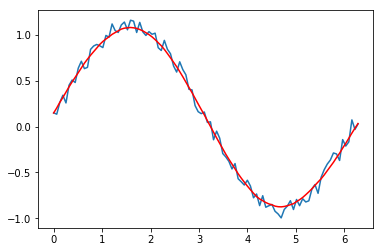

In [64]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
        if window_size % 2 != 1 or window_size < 1:
            raise TypeError("window_size size must be a positive odd number")
        if window_size < order + 2:
            raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
x = np.linspace(0,2*np.pi,100)
y = np.sin(x) + np.random.random(100) * 0.2
yhat = savitzky_golay(y, 51, 3) # window size 51, polynomial order 3

plt.plot(x,y)
plt.plot(x,yhat, color='red')
plt.show()

In [86]:
%load_ext autoreload
from feature_interval_extraction import get_interval_collector

def get_well_with_distance_features__(well):
    def add_feature_last(well_in, shift_last, name):
        well_in[name + '_last_' + str(shift_last / 5)] = well_in[name].shift(periods=-shift_last)

    def add_feature_next(well_in, shift_next, name):
        well_in[name + '_next_' + str(shift_next / 5)] = well_in[name].shift(periods=+shift_next)

    distance_meter = [3, 6, 9, 12, 15]
    distance_shift = [meter * 5 for meter in distance_meter]
    well_copy = well.copy()

    for shift in distance_shift:
        add_feature_last(well_copy, shift, 'GR')
        add_feature_last(well_copy, shift, 'SP')
        add_feature_last(well_copy, shift, 'BK')
        add_feature_last(well_copy, shift, 'NKTB')

        add_feature_next(well_copy, shift, 'GR')
        add_feature_next(well_copy, shift, 'SP')
        add_feature_next(well_copy, shift, 'BK')
        add_feature_next(well_copy, shift, 'NKTB')

    return well_copy


def get_df_interval_result(well, intervals):
    dfs_parts = []
    for interval in intervals:
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            df_part_min = well[well['MD'] >= min_]
            df_part = df_part_min[df_part_min['MD'] <= max_]
        else:
            df_part_min = well[well['MD'] <= min_]
            df_part = df_part_min[df_part_min['MD'] >= max_]
        dfs_parts.append(df_part)
    all = pd.concat(dfs_parts)
    return all.drop_duplicates()


def get_df_intervals_result(well, intervals):
    dfs_parts = []
    for interval in intervals:
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            df_part_min = well[well['MD'] >= min_]
            df_part = df_part_min[df_part_min['MD'] <= max_]
        else:
            df_part_min = well[well['MD'] <= min_]
            df_part = df_part_min[df_part_min['MD'] >= max_]
        dfs_parts.append(df_part)
    return dfs_parts


def get_df_middle_intervals_result(well, intervals):
    def get_left_md(interval):
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            return min_
        else:
            return max_

    def get_right_md(interval):
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            return max_
        else:
            return min_

    if len(intervals) == 0:
        return 0
    well_copy = well.copy()
    if len(intervals) == 1:
        left = get_left_md(intervals[0])
        right = get_right_md(intervals[0])
        left_df = well_copy[well_copy['MD'] < left]
        right_df = well_copy[well_copy['MD'] > right]
        return [left_df, right_df]

    middle_interval_dfs = []
    for index, interval in enumerate(intervals):
        if index == 0:
            left = get_left_md(intervals[index])
            left_df = well_copy[well_copy['MD'] < left]
            middle_interval_dfs.append(left_df)
            continue
        if index == len(intervals) - 1:
            right = get_right_md(intervals[index])
            right_df = well_copy[well_copy['MD'] > right]
            middle_interval_dfs.append(right_df)
            continue
        right_current = get_right_md(intervals[index])
        left_next = get_left_md(intervals[index + 1])
        df_part_right = well_copy[well_copy['MD'] > right_current]
        df_part = df_part_right[df_part_right['MD'] < left_next]
        if not df_part.empty:
            middle_interval_dfs.append(df_part)
    return middle_interval_dfs


def add_statistic_for_interval(middle_interval_dfs, feature_names, new_feature_prefix):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        for name in feature_names:
            part['max_' + new_feature_prefix + name] = part[name].max()
            part['min_' + new_feature_prefix + name] = part[name].min()
            if part[name].max() == part[name].min():
                part['std_' + new_feature_prefix + name] = 0
            else:
                part['std_' + new_feature_prefix + name] = part[name].std()
            part['mean_' + new_feature_prefix + name] = part[name].mean()
        results.append(part)
    return pd.concat(results)


def get_with_interval_feature_extraction(well, features_name_for_extraction,
                                         percent_change_border, new_feature_prefix, features_name_for_statistic):
    intervals = get_interval_collector(well, features_name_for_extraction, percent_change_border)
    interval_df = get_df_intervals_result(well, intervals)
    middle_interval_df = get_df_middle_intervals_result(well, intervals)
    with_statistic_middle = add_statistic_for_interval(middle_interval_df, features_name_for_statistic,
                                                       new_feature_prefix)
    with_statistic_intervals = add_statistic_for_interval(interval_df, features_name_for_statistic, new_feature_prefix)
    concat_df = pd.concat([with_statistic_middle, with_statistic_intervals])
    remove_duplicates = concat_df.drop_duplicates(subset='MD', keep="last")
    return remove_duplicates.sort_index()


def add_interval_column(middle_interval_dfs, new_column_name, feature_sp_gr):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['max_' + new_column_name] = part[feature_sp_gr].max()
        part['min_' + new_column_name] = part[feature_sp_gr].min()
        results.append(part)
    return pd.concat(results)


def add_interval_column_nulls(middle_interval_dfs, new_column_name):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['max_' + new_column_name] = -9999
        part['min_' + new_column_name] = -9999
        results.append(part)
    return pd.concat(results)


def get_column_with_interval(well, features_name_for_extraction,
                             percent_change_border, new_column_name, feature_sp_or_gr):
    intervals = get_interval_collector(well, features_name_for_extraction, percent_change_border)
    interval_df = get_df_intervals_result(well, intervals)
    middle_interval_df = get_df_middle_intervals_result(well, intervals)
    with_statistic_middle = add_interval_column_nulls(middle_interval_df, new_column_name)
    with_statistic_intervals = add_interval_column(interval_df, new_column_name, feature_sp_or_gr)
    concat_df = pd.concat([with_statistic_middle, with_statistic_intervals])
    remove_duplicates = concat_df.drop_duplicates(subset='MD', keep="last")
    return remove_duplicates.sort_index()


def get_well_with_features_df(wells, feature_names, percents_borders):
    wells_return = []
    wells_nulls = []
    index_well = 0
    for well in wells:
        well_copy = well.copy()
        well_copy = get_well_with_distance_features__(well_copy)

        name_feature_extraction = feature_names[0] + '_savitzky_golay'
        print(feature_names[0] + '_' + str(index_well))
        well_copy[name_feature_extraction] = savitzky_golay(well_copy[feature_names[0]].values, 35, 5, 1)
        index_well = index_well + 1
        min_ = well_copy[name_feature_extraction].min()
        well_copy[name_feature_extraction] = well_copy[name_feature_extraction].apply(lambda x: x + abs(min_))
        for border in percents_borders:
            new_feature_prefix = feature_names[0] + 'interval_' + str(border) + '_'
            well_copy = get_with_interval_feature_extraction(well=well_copy,
                                                             features_name_for_extraction=name_feature_extraction,
                                                             percent_change_border=border,
                                                             new_feature_prefix=new_feature_prefix,
                                                             features_name_for_statistic=['SP', 'GR'])
        wells_return.append(well_copy)

        # well_with_new_features = get_with_interval_feature_extraction(well_copy, name_feature_extraction, 0.05,feature_names)
        # well_with_new_features = get_column_with_interval(well_copy, 
        #                                                   name_feature_extraction, 0.05,
        #                                                   'interval_0.05_' + feature_names[0],
        #                                                  feature_names[0])
        # well_with_new_features = get_column_with_interval(well_with_new_features, 
        #                                                   name_feature_extraction, 0.1,
        #                                                   'interval_0.1_' + feature_names[0],
        #                                                  feature_names[0])
        # well_with_new_features = get_column_with_interval(well_with_new_features, 
        #                                                   name_feature_extraction, 0.15,
        #                                                   'interval_0.15_' + feature_names[0],
        #                                                  feature_names[0])
        # well_with_new_features = get_column_with_interval(well_with_new_features, 
        #                                                   name_feature_extraction, 0.2,
        #                                                   'interval_0.2_' + feature_names[0],
        #                                                  feature_names[0])
        # well_with_new_features = get_column_with_interval(well_with_new_features, 
        #                                                   name_feature_extraction, 0.25,
        #                                                   'interval_0.25_' + feature_names[0],
        #                                                  feature_names[0])

    print(len(wells_nulls))
    return wells_return


well_with_features = get_well_with_features_df(wells_add_detrends_df, ['SP'], [0.1])
#well_with_features = get_well_with_features_df(well_with_features, ['GR'], [0.05, 0.1, 0.15, 0.2])
for_ml_preprocessing = pd.concat(well_with_features)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
SP_0
SP_1
SP_2
SP_3
SP_4
SP_5
SP_6
SP_7
SP_8
SP_9
SP_10
SP_11
SP_12
SP_13
SP_14
SP_15
0


KeyError: 'min_GRinterval_0.15_GR'

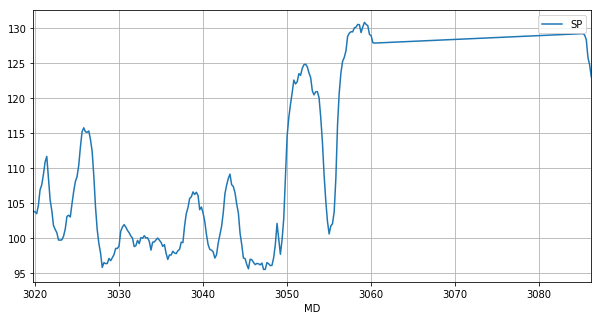

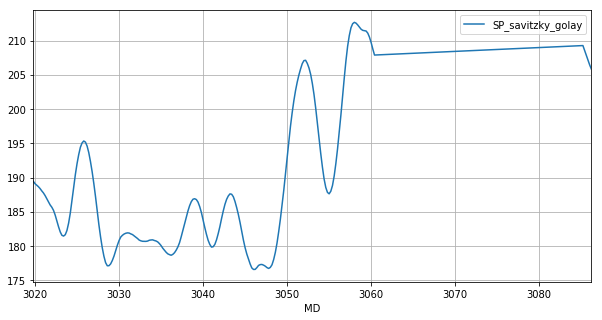

In [39]:
first = well_with_features[0].copy()
diference_border = -9
first[first['Facies'] > diference_border].plot(x='MD', y="SP", figsize=(10, 5), grid=True)
first[first['Facies'] > diference_border].plot(x='MD', y="SP_savitzky_golay", figsize=(10, 5), grid=True)
first[first['Facies'] > diference_border].plot(x='MD', y="min_GRinterval_0.15_GR", figsize=(10, 5), grid=True)
first[first['Facies'] > diference_border].plot(x='MD', y="Facies", figsize=(10, 5), grid=True)
#first[first['Facies'] > diference_border].plot(x='MD', y="GR", figsize=(10, 5), grid=True)
first[first['Facies'] > diference_border].plot(x='MD', y="max_GRinterval_0.15_GR", figsize=(10, 5), grid=True)

In [91]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
def standarize_feature(train_df, cols, test_df=0):
    def save_simple_model(model, name):
        import pickle
        from sklearn.externals import joblib
        with open(name, 'wb') as f:
             pickle.dump(model, f)
            
    def load_simple_model(name):
        from sklearn.externals import joblib
        test_load_model = joblib.load(name)
        return test_load_model
    
    scaler = RobustScaler(quantile_range=(25.0, 75.0))
    for col in cols:
        train_df[col] = scaler.fit_transform(train_df[col].values.reshape(-1,1).astype(np.float32))
        #if type(test_df)!=int:
            #test_df[col] = scaler.transform(test_df[col].values.reshape(-1,1).astype(np.float32))
    save_simple_model(scaler, 'RobustScaler')
    return None

def get_well_with_features_df_rebost(wells):
    wells_return = []
    wells_nulls = []
    for well in wells:
        well_copy = well.copy().dropna()
        if not well_copy.empty:
            standarize_feature(well_copy, [i for i in well_copy.columns if i!= 'wellName' 
                                       and i!='datasetName'  
                                       and i!='MD'
                                       and i!='LAYER'
                                       and i!='LIT'
                                       and i!='Facies'])
            wells_return.append(well_copy)
    print(len(wells_nulls))
    return wells_return

well_with_features_ = get_well_with_features_df_rebost(well_with_features)
for_ml_preprocessing = pd.concat(well_with_features_)

0


In [92]:
first.columns
    

Index(['wellName', 'datasetName', 'MD', 'BK', 'Facies', 'GR', 'LAYER', 'LIT',
       'NKTB', 'SP', 'SP_detrend', 'GR_last_3.0', 'SP_last_3.0', 'BK_last_3.0',
       'NKTB_last_3.0', 'GR_next_3.0', 'SP_next_3.0', 'BK_next_3.0',
       'NKTB_next_3.0', 'GR_last_6.0', 'SP_last_6.0', 'BK_last_6.0',
       'NKTB_last_6.0', 'GR_next_6.0', 'SP_next_6.0', 'BK_next_6.0',
       'NKTB_next_6.0', 'GR_last_9.0', 'SP_last_9.0', 'BK_last_9.0',
       'NKTB_last_9.0', 'GR_next_9.0', 'SP_next_9.0', 'BK_next_9.0',
       'NKTB_next_9.0', 'GR_last_12.0', 'SP_last_12.0', 'BK_last_12.0',
       'NKTB_last_12.0', 'GR_next_12.0', 'SP_next_12.0', 'BK_next_12.0',
       'NKTB_next_12.0', 'GR_last_15.0', 'SP_last_15.0', 'BK_last_15.0',
       'NKTB_last_15.0', 'GR_next_15.0', 'SP_next_15.0', 'BK_next_15.0',
       'NKTB_next_15.0', 'SP_savitzky_golay', 'max_SPinterval_0.15_SP',
       'min_SPinterval_0.15_SP', 'std_SPinterval_0.15_SP',
       'mean_SPinterval_0.15_SP', 'max_SPinterval_0.15_GR',
       'min_SPi

In [93]:
well_with_features

[     wellName datasetName      MD    BK  Facies     GR  LAYER   LIT      NKTB  \
 0     spk1521   TrainLogs  2011.0  4.42   -9999  13.60  -9999 -9999  2.968678   
 1     spk1521   TrainLogs  2011.2  4.30   -9999  13.51  -9999 -9999  2.937724   
 2     spk1521   TrainLogs  2011.4  4.31   -9999  13.17  -9999 -9999  2.973814   
 3     spk1521   TrainLogs  2011.6  4.28   -9999  13.03  -9999 -9999  2.989185   
 4     spk1521   TrainLogs  2011.8  4.26   -9999  12.94  -9999 -9999  2.968678   
 5     spk1521   TrainLogs  2012.0  4.41   -9999  12.64  -9999 -9999  3.024832   
 6     spk1521   TrainLogs  2012.2  4.50   -9999  12.61  -9999 -9999  3.055148   
 7     spk1521   TrainLogs  2012.4  5.00   -9999  12.93  -9999 -9999  3.105200   
 8     spk1521   TrainLogs  2012.6  4.75   -9999  13.44  -9999 -9999  3.139893   
 9     spk1521   TrainLogs  2012.8  4.59   -9999  13.41  -9999 -9999  3.115140   
 10    spk1521   TrainLogs  2013.0  4.63   -9999  13.23  -9999 -9999  3.134954   
 11    spk1521  

In [94]:
for_ml_preprocessing.describe()

MD            BK        Facies            GR           LIT  \
count  76000.000000  76000.000000  76000.000000  76000.000000  76000.000000   
mean    2114.468524    422.254242  -9678.864276      0.214534  -8079.971368   
std      383.406817   2019.877563   1760.758124      1.868731   3938.267208   
min      722.000000   -778.084656  -9999.000000     -2.791667  -9999.000000   
25%     1872.200000     -0.200000  -9999.000000     -0.451723  -9999.000000   
50%     2135.900000      0.000000  -9999.000000      0.000000  -9999.000000   
75%     2399.800000      0.533638  -9999.000000      0.545470  -9999.000000   
max     3078.000000  29840.919922     12.000000     31.495115      6.000000   

               NKTB            SP    SP_detrend   GR_last_3.0   SP_last_3.0  \
count  76000.000000  76000.000000  76000.000000  76000.000000  76000.000000   
mean       0.036118     -0.304843     -0.308671      0.212209     -0.306883   
std        0.918763      0.787132      0.827876      1.867621      0.788869   
min       -2.756098     -3.807933     -3.667797     -2.794444     -3.808875   
25%       -0.510638     -0.702139     -0.743436     -0.452778     -0.704486   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.486486      0.255716      0.247488      0.542636      0.254942   
max       11.904255      1.487345      1.285463     31.395857      1.477064   

       ...  NKTB_next_15.0  SP_savitzky_golay  max_SPinterval_0.1_SP  \
count  ...    76000.000000       76000.000000           76000.000000   
mean   ...        0.035290           0.000254              -0.594018   
std    ...        0.903291           1.778846               1.777268   
min    ...       -2.690477         -10.317645             -15.058598   
25%    ...       -0.510204          -0.521859              -0.632136   
50%    ...        0.000000           0.000000               0.000000   
75%    ...        0.484536           0.477143               0.310879   
max    ...       11.556701          10.253470               2.689548   

       min_SPinterval_0.1_SP  std_SPinterval_0.1_SP  mean_SPinterval_0.1_SP  \
count           76000.000000           76000.000000            76000.000000   
mean               -0.091266               0.271383               -0.226579   
std                 0.555246               0.790249                0.756735   
min                -1.734835              -0.828922               -3.646766   
25%                -0.549696              -0.321721               -0.608333   
50%                 0.000000               0.000000                0.000000   
75%                 0.378832               0.650631                0.336476   
max                 1.619344               3.399125                1.537652   

       max_SPinterval_0.1_GR  min_SPinterval_0.1_GR  std_SPinterval_0.1_GR  \
count           76000.000000           76000.000000           76000.000000   
mean                1.102392               0.118742               1.038767   
std                 5.147888               1.333999               4.900529   
min                -2.326705              -2.947367              -1.708084   
25%                -0.449704              -0.461497              -0.434564   
50%                 0.000000               0.000000               0.000000   
75%                 0.550000               0.536458               0.621559   
max                38.257267              32.684200              44.447823   

       mean_SPinterval_0.1_GR  
count            76000.000000  
mean                 0.276986  
std                  1.799632  
min                 -2.192906  
25%                 -0.379966  
50%                  0.000000  
75%                  0.616502  
max                 23.781298  

[8 rows x 57 columns]

In [95]:
for_ml_preprocessing[for_ml_preprocessing['Facies'] > -1].describe()

MD            BK       Facies           GR          LIT  \
count  2432.000000   2432.000000  2432.000000  2432.000000  2432.000000   
mean   2616.383635   2191.111328     5.241365    -0.170986  -100.536595   
std     135.019974   4139.016113     2.563494     0.737199  1008.996224   
min    2507.600000     -0.934485     0.000000    -1.926641 -9999.000000   
25%    2551.200000      0.221078     5.000000    -0.765100     1.000000   
50%    2573.400000      0.999947     5.000000    -0.228916     1.000000   
75%    2602.600000      6.741164     7.000000     0.381096     4.000000   
max    3060.400000  10177.602539    12.000000     1.942326     5.000000   

              NKTB           SP   SP_detrend  GR_last_3.0  SP_last_3.0  ...  \
count  2432.000000  2432.000000  2432.000000  2432.000000  2432.000000  ...   
mean      0.977468    -0.130677    -0.539040    -0.131031    -0.103372  ...   
std       1.035071     0.440012     0.536312     0.748038     0.432137  ...   
min      -1.405964    -1.707471    -2.852888    -1.924783    -1.734725  ...   
25%       0.276596    -0.378622    -0.804594    -0.741503    -0.331664  ...   
50%       0.799269    -0.046715    -0.391255    -0.128765    -0.021825  ...   
75%       1.468141     0.175018    -0.170034     0.444549     0.185415  ...   
max       6.766817     0.861024     0.215628     1.935910     0.877302  ...   

       NKTB_next_15.0  SP_savitzky_golay  max_SPinterval_0.1_SP  \
count     2432.000000        2432.000000            2432.000000   
mean         0.351220           0.061834              -0.318894   
std          1.348426           1.221182               0.821139   
min         -2.690477          -7.317465              -3.463757   
25%         -0.629511          -0.425246              -0.831808   
50%          0.314199           0.053609              -0.098123   
75%          1.072642           0.519841               0.229513   
max          6.715325           5.149268               1.211064   

       min_SPinterval_0.1_SP  std_SPinterval_0.1_SP  mean_SPinterval_0.1_SP  \
count            2432.000000            2432.000000             2432.000000   
mean                0.080081               0.082108               -0.022578   
std                 0.355963               0.630531                0.394238   
min                -0.802963              -0.791126               -1.513165   
25%                -0.137582              -0.295382               -0.270401   
50%                 0.081146              -0.108481                0.070263   
75%                 0.370026               0.278108                0.260956   
max                 0.841540               2.815671                0.929896   

       max_SPinterval_0.1_GR  min_SPinterval_0.1_GR  std_SPinterval_0.1_GR  \
count            2432.000000            2432.000000            2432.000000   
mean                0.733173              -0.358575               1.599531   
std                 2.809463               0.826904               3.940275   
min                -2.232365              -2.347086              -1.328517   
25%                -0.195266              -0.846813               0.070578   
50%                 0.355555              -0.701657               0.812078   
75%                 0.908284               0.224168               1.723021   
max                27.375006               2.425671              33.315941   

       mean_SPinterval_0.1_GR  
count             2432.000000  
mean                 0.016139  
std                  1.122217  
min                 -1.689156  
25%                 -0.506974  
50%                 -0.071962  
75%                  0.364139  
max                  9.505890  

[8 rows x 57 columns]

In [96]:


def get_features_filtering(wells):
    well_copy = wells.copy()
    del well_copy['LAYER']
    del well_copy['datasetName']
    #del well_copy['BK']
    #del well_copy['NKTB']
    well_copy = well_copy[well_copy['Facies'] > -1]
    for name_feature in well_copy.columns:
        if name_feature != 'wellName' and name_feature != 'Facies':
            print(name_feature)
            well_copy = well_copy[well_copy[name_feature] > -999]
    return well_copy.dropna()

def get_for_learn_featres(for_all_feature_df):
    feature = for_all_feature_df.copy()
    del feature['Facies']
    del feature['wellName']
    del feature['LIT']
    del feature['MD']
    return feature


def get_for_learn_target_class(for_all_feature_df):
    target_class = for_all_feature_df.copy()
    target_class = target_class['Facies']#.apply(lambda x: float(x))
    return target_class


for_ml_with_features = get_features_filtering(for_ml_preprocessing)
display(for_ml_with_features.describe())

features = get_for_learn_featres(for_ml_with_features)
target_facies = get_for_learn_target_class(for_ml_with_features)
display(features)

MD
BK
GR
LIT
NKTB
SP
SP_detrend
GR_last_3.0
SP_last_3.0
BK_last_3.0
NKTB_last_3.0
GR_next_3.0
SP_next_3.0
BK_next_3.0
NKTB_next_3.0
GR_last_6.0
SP_last_6.0
BK_last_6.0
NKTB_last_6.0
GR_next_6.0
SP_next_6.0
BK_next_6.0
NKTB_next_6.0
GR_last_9.0
SP_last_9.0
BK_last_9.0
NKTB_last_9.0
GR_next_9.0
SP_next_9.0
BK_next_9.0
NKTB_next_9.0
GR_last_12.0
SP_last_12.0
BK_last_12.0
NKTB_last_12.0
GR_next_12.0
SP_next_12.0
BK_next_12.0
NKTB_next_12.0
GR_last_15.0
SP_last_15.0
BK_last_15.0
NKTB_last_15.0
GR_next_15.0
SP_next_15.0
BK_next_15.0
NKTB_next_15.0
SP_savitzky_golay
max_SPinterval_0.1_SP
min_SPinterval_0.1_SP
std_SPinterval_0.1_SP
mean_SPinterval_0.1_SP
max_SPinterval_0.1_GR
min_SPinterval_0.1_GR
std_SPinterval_0.1_GR
mean_SPinterval_0.1_GR


MD            BK       Facies           GR          LIT  \
count  2407.000000   2407.000000  2407.000000  2407.000000  2407.000000   
mean   2616.836311   2109.881348     5.227669    -0.169096     2.272538   
std     135.646068   4082.560059     2.568694     0.737688     1.530137   
min    2507.600000     -0.934485     0.000000    -1.926641     1.000000   
25%    2551.000000      0.206834     5.000000    -0.763035     1.000000   
50%    2573.600000      0.999920     5.000000    -0.227842     1.000000   
75%    2603.000000      6.144815     7.000000     0.386310     4.000000   
max    3060.400000  10177.602539    12.000000     1.942326     5.000000   

              NKTB           SP   SP_detrend  GR_last_3.0  SP_last_3.0  ...  \
count  2407.000000  2407.000000  2407.000000  2407.000000  2407.000000  ...   
mean      0.966007    -0.132674    -0.543110    -0.135070    -0.107370  ...   
std       1.026655     0.441544     0.537291     0.747985     0.432507  ...   
min      -1.405964    -1.707471    -2.852888    -1.924783    -1.734725  ...   
25%       0.273533    -0.381209    -0.806790    -0.748140    -0.337579  ...   
50%       0.795872    -0.049217    -0.393450    -0.137404    -0.027430  ...   
75%       1.438776     0.174211    -0.173571     0.437242     0.182965  ...   
max       6.766817     0.861024     0.215628     1.935910     0.877302  ...   

       NKTB_next_15.0  SP_savitzky_golay  max_SPinterval_0.1_SP  \
count     2407.000000        2407.000000            2407.000000   
mean         0.368857           0.060799              -0.320861   
std          1.343972           1.225720               0.825037   
min         -2.690477          -7.317465              -3.463757   
25%         -0.578515          -0.425693              -0.831808   
50%          0.333332           0.046266              -0.086986   
75%          1.083228           0.518104               0.229513   
max          6.715325           5.149268               1.211064   

       min_SPinterval_0.1_SP  std_SPinterval_0.1_SP  mean_SPinterval_0.1_SP  \
count            2407.000000            2407.000000             2407.000000   
mean                0.077233               0.083830               -0.024340   
std                 0.356330               0.633428                0.395890   
min                -0.802963              -0.791126               -1.513165   
25%                -0.137582              -0.295382               -0.285814   
50%                 0.081146              -0.108481                0.070263   
75%                 0.370026               0.278108                0.260956   
max                 0.841540               2.815671                0.929896   

       max_SPinterval_0.1_GR  min_SPinterval_0.1_GR  std_SPinterval_0.1_GR  \
count            2407.000000            2407.000000            2407.000000   
mean                0.735816              -0.357432               1.603947   
std                 2.823844               0.831006               3.960395   
min                -2.232365              -2.347086              -1.328517   
25%                -0.195266              -0.851343               0.070578   
50%                 0.292135              -0.701657               0.710269   
75%                 0.908284               0.224168               1.727347   
max                27.375006               2.425671              33.315941   

       mean_SPinterval_0.1_GR  
count             2407.000000  
mean                 0.019498  
std                  1.127527  
min                 -1.689156  
25%                 -0.506974  
50%                 -0.071962  
75%                  0.364139  
max                  9.505890  

[8 rows x 57 columns]

BK        GR      NKTB        SP  SP_detrend  GR_last_3.0  \
5044    1.941177 -0.387707  1.538244 -0.419696   -1.057833    -1.004728   
5045    1.887701 -0.576832  1.980251 -0.422918   -1.061315    -1.087470   
5046    2.935829 -0.612293  2.182102 -0.434883   -1.073645    -1.113475   
5047    4.764706 -0.673759  2.220773 -0.381500   -1.019851    -1.108747   
5048    5.657754 -0.631206  2.207896 -0.278417   -0.915768    -1.073286   
5049    7.085562 -0.472813  2.240062 -0.245283   -0.882464    -0.990544   
5050    6.080214 -0.276596  2.019592 -0.177635   -0.814235    -0.945626   
5051    3.374332  0.139480  1.579160 -0.095260   -0.731106    -0.976359   
5052    1.925134  0.664303  1.077581 -0.058445   -0.694076    -1.037825   
5053    2.641712  0.723404  1.056153 -0.199264   -0.836788    -1.059102   
5054    2.893048  0.293144  1.469713 -0.344225   -0.983691    -1.002364   
5055    2.508022 -0.087470  1.647013 -0.415095   -1.055623    -0.848700   
5056    2.780749 -0.224586  1.741318 -0.513116   -1.155029    -0.631206   
5057    3.844920 -0.472813  1.834834 -0.538426   -1.180863    -0.340426   
5058    4.363636 -0.834515  1.934183 -0.560516   -1.203436    -0.104019   
5059    4.743316 -1.004728  2.104379 -0.608376   -1.252086     0.075650   
5060    5.208556 -1.087470  2.246483 -0.608836   -1.252774     0.328605   
5061    4.556150 -1.113475  2.123858 -0.606995   -1.251134     0.276596   
5062    4.048129 -1.108747  2.278544 -0.582145   -1.226212    -0.073286   
5063    3.438503 -1.073286  2.450209 -0.535665   -1.179403    -0.274232   
5064    2.598931 -0.990544  2.437575 -0.452830   -1.095808    -0.394799   
5065    2.737968 -0.945626  2.462828 -0.445467   -1.088580    -0.574468   
5066    3.310161 -0.976359  2.342410 -0.456512   -1.099978    -0.789598   
5067    4.090909 -1.037825  2.252901 -0.369996   -1.012658    -1.040189   
5068    4.358289 -1.059102  2.058802 -0.289922   -0.931857    -1.276596   
5069    8.368984 -1.002364  1.761421 -0.224575   -0.865957    -1.399527   
5070    5.192514 -0.848700  1.455954 -0.191901   -0.833118    -1.340425   
5071    2.379679 -0.631206  1.106082 -0.118730   -0.759302    -1.238770   
5072    1.417112 -0.340426  0.669890  0.001840   -0.637524    -1.269503   
5073    2.673797 -0.104019  0.150533  0.104003   -0.534372    -1.321513   
...          ...       ...       ...       ...         ...          ...   
124790 -0.261699 -0.374660  0.586010 -0.504886   -0.927426    -0.440444   
124791 -0.494241 -0.082956  0.628441 -0.493695   -0.914817    -0.334239   
124792 -0.539237  0.039891  0.712156 -0.455161   -0.870814    -0.324728   
124793 -0.573434  0.281732  0.377867 -0.428941   -0.840949    -0.353714   
124794 -0.488481  0.779918  0.831423 -0.420530   -0.831531    -0.352808   
124795 -0.076674  0.728921  0.934060 -0.551671   -0.982338    -0.296649   
124796  0.348452  0.245693  1.026950 -0.758586   -1.220144     0.038044   
124797  0.275018 -0.209429  0.955849 -0.916259   -1.401413     0.293478   
124798 -0.003960 -0.453309  0.934060 -0.992075   -1.488700     0.424366   
124799  0.268898 -0.683364  0.482225 -0.911232   -1.396122     0.200634   
124800  0.798056 -0.898232  1.115252 -0.773284   -1.237977    -0.016757   
124801  1.173866 -0.985041  1.555621 -0.639447   -1.084553     0.104846   
124802  0.828294 -0.740707  1.483946 -0.586246   -1.023710     0.341485   
124803  0.210583 -0.495920  0.981079 -0.630197   -1.074411     0.439538   
124804 -0.225342 -0.516546  0.706422 -0.732702   -1.192341     0.350090   
124805 -0.041397 -0.432684  0.616400 -0.822578   -1.295769     0.357110   
124806 -0.056516 -0.326383  0.583716 -0.914349   -1.401375     0.540761   
124807 -0.143629 -0.316863  0.845184 -0.936336   -1.426858     0.570879   
124808 -0.421166 -0.345875  0.724197 -0.881731   -1.364404     0.103034   
124809 -0.438445 -0.344968  0.647936 -0.764030   -1.229505    -0.114810   
124810 -0.582074 -0.288758  0.294152 -0.610623   -1.053613    -0.040082   
124811 -0.465803  0.046238  0.673739 -0

In [97]:
def p(target, labels):
    print('RMSE ошибка равна',mean_squared_error(target, labels))
    print(classification_report(target, labels))
    
def p_cross_val(model, train, labels):
    from sklearn.model_selection import StratifiedKFold
    
    print('cross_val_predict')
    skf = StratifiedKFold(n_splits=9)
    predicted = cross_val_predict(model, train, labels, cv=skf)
    print(classification_report(labels, predicted))
    
    #scores = cross_val_score(model, train, labels, cv=skf)
    #print("---cross_val_score---")
    #print("CV scores: {0}".format(scores))
    #print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [131]:
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import RFE

def p_cross_val(model, train, labels):
    from sklearn.model_selection import StratifiedKFold

    print('cross_val_predict')
    skf = StratifiedKFold(n_splits=10)
    predicted = cross_val_predict(model, train, labels, cv=skf)
    print(classification_report(labels, predicted))
    rmse = mean_squared_error(labels, predicted)
    print('rmse ' + str(rmse))

    scores = cross_val_score(model, train, labels, cv=skf)
    print("---cross_val_score---")
    print("CV scores: {0}".format(scores))
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


def get_optimization_params(train, labels, rfe_count):
    ridge_model_cv = get_best_model_ml(train, labels, rfe_count)
    rmse = get_oprimization(ridge_model_cv, train, labels)
    return rmse


def get_oprimization(model, train, labels):
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=9)
    predicted = cross_val_predict(model, train, labels, cv=skf)
    rmse = mean_squared_error(labels, predicted)
    return rmse


def get_best_model_ml(train, labels, rfe_count):
    model = RidgeClassifier(random_state=18, normalize=True)
    # train_data = Pool(train,  labels)

    # model = CatBoostClassifier(iterations=10,logging_level='Silent',class_weights=[0.9, 2])
    rfe = RFE(estimator=model, n_features_to_select=rfe_count)
    rfe = rfe.fit(train, labels)
    return rfe


def print_cross_val_predict(train, labels, rfe_count):
    ridge_model_cv = get_best_model_ml(train, labels, rfe_count)
    p_cross_val(ridge_model_cv, train, labels)
    print(ridge_model_cv.support_)
    print(sorted(zip(map(lambda x: round(x, 4), ridge_model_cv.ranking_), train.columns)))


def start_optimizer(train, labels):
    step_md = 4
    max_count = 250
    rmse_min = 50
    for rfe_count in range(50, max_count, step_md):
        rmse = get_optimization_params(train, labels, rfe_count)
        if rmse < rmse_min:
            rmse_min = rmse
            print('Rmse ' + str(rmse_min) + ' rfe_count ' + str(rfe_count))
            print_cross_val_predict(train, labels, rfe_count)

start_optimizer(features, target_facies)


Rmse 6.213543830494391 rfe_count 50
cross_val_predict


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.57      0.02      0.03       233
           1       0.97      0.77      0.86        86
           3       0.00      0.00      0.00        85
           5       0.65      0.88      0.74      1207
           7       0.56      0.62      0.59       581
           8       0.74      0.26      0.39       110
          12       0.00      0.00      0.00       105

   micro avg       0.63      0.63      0.63      2407
   macro avg       0.50      0.36      0.37      2407
weighted avg       0.58      0.63      0.57      2407

rmse 6.148732862484421
---cross_val_score---
CV scores: [0.7704918  0.6872428  0.75308642 0.61570248 0.40082645 0.73333333
 0.46861925 0.76890756 0.59243697 0.53361345]
Accuracy: 0.63 (+/- 0.25)
[False  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  

In [99]:
def p_cross_val(model, train, labels):
    from sklearn.model_selection import StratifiedKFold

    print('cross_val_predict')
    skf = StratifiedKFold(n_splits=9)
    predicted = cross_val_predict(model, train, labels, cv=skf)
    print(classification_report(labels, predicted))
    rmse = mean_squared_error(labels, predicted)
    print('rmse ' + str(rmse))
    
def get_OneVsRestClassifier_randomForestRegressor(train, labels):
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
    
    reg = RandomForestClassifier(random_state = 18, bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, verbose=0, warm_start=False)

    OVR = OneVsRestClassifier(reg,n_jobs=-1)
    OVR.fit(train, labels)
    
    p(labels, OVR.predict(train).round())
    p_cross_val(OVR, train, labels)
    return OVR

prod_OneVsRest_RandomForest_model = get_OneVsRestClassifier_randomForestRegressor(features, target_facies) 

RMSE ошибка равна 0.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       233
           1       1.00      1.00      1.00        86
           3       1.00      1.00      1.00        85
           5       1.00      1.00      1.00      1207
           7       1.00      1.00      1.00       581
           8       1.00      1.00      1.00       110
          12       1.00      1.00      1.00       105

   micro avg       1.00      1.00      1.00      2407
   macro avg       1.00      1.00      1.00      2407
weighted avg       1.00      1.00      1.00      2407

cross_val_predict
              precision    recall  f1-score   support

           0       0.74      0.59      0.66       233
           1       0.71      0.84      0.77        86
           3       0.83      1.00      0.90        85
           5       0.82      0.86      0.84      1207
           7       0.79      0.72      0.75       581
           8       0.77      0.85     

In [100]:
importances = prod_OneVsRest_RandomForest_model.estimators_[4].feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature importances:")
for f, idx in enumerate(indices):
    print("{:2d}. feature '{:5s}' ({:.4f})".format(f + 1, features.columns[idx], importances[idx]))

Feature importances:
 1. feature 'mean_SPinterval_0.1_SP' (0.0971)
 2. feature 'min_SPinterval_0.1_SP' (0.0530)
 3. feature 'max_SPinterval_0.1_SP' (0.0514)
 4. feature 'std_SPinterval_0.1_SP' (0.0473)
 5. feature 'mean_SPinterval_0.1_GR' (0.0466)
 6. feature 'max_SPinterval_0.1_GR' (0.0442)
 7. feature 'SP   ' (0.0435)
 8. feature 'std_SPinterval_0.1_GR' (0.0414)
 9. feature 'BK_next_3.0' (0.0307)
10. feature 'min_SPinterval_0.1_GR' (0.0294)
11. feature 'BK   ' (0.0289)
12. feature 'BK_next_6.0' (0.0254)
13. feature 'SP_last_3.0' (0.0250)
14. feature 'SP_detrend' (0.0224)
15. feature 'BK_last_3.0' (0.0206)
16. feature 'BK_next_12.0' (0.0206)
17. feature 'BK_next_9.0' (0.0205)
18. feature 'BK_next_15.0' (0.0183)
19. feature 'NKTB_next_15.0' (0.0168)
20. feature 'BK_last_6.0' (0.0147)
21. feature 'BK_last_12.0' (0.0143)
22. feature 'BK_last_9.0' (0.0140)
23. feature 'SP_next_3.0' (0.0140)
24. feature 'SP_last_6.0' (0.0139)
25. feature 'NKTB_next_12.0' (0.0127)
26. feature 'SP_next_6.0' 

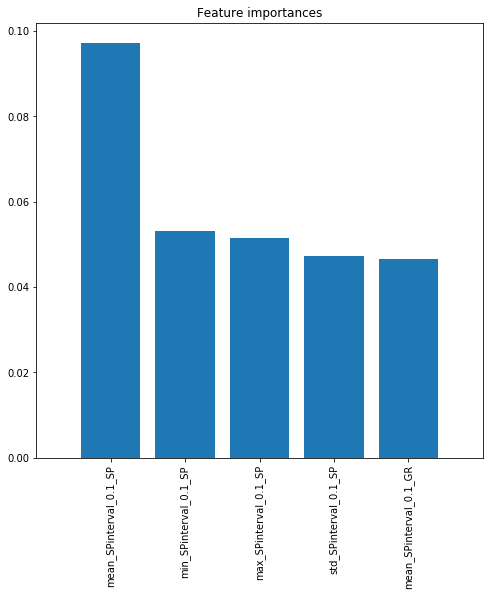

In [101]:
import matplotlib.pyplot as plt
%matplotlib inline
d_first = 5
plt.figure(figsize=(8, 8))
plt.title("Feature importances")
plt.bar(range(d_first), importances[indices[:d_first]], align='center')
plt.xticks(range(d_first), np.array(features.columns)[indices[:d_first]], rotation=90)
plt.xlim([-1, d_first]);

In [102]:
def get_KNeighborsClassifier(x ,target):
    X_train, X_test, y_train, y_test = train_test_split(x, target, train_size=0.7, stratify=target)
    for k in range(1,15):
        classifier = KNeighborsClassifier(n_neighbors=k)
        classifier.fit(X_train, y_train)
        print(" n_neighbors ")
        print(k)
        #print(classification_report(y_test, classifier.predict(X_test)))
        predicted = cross_val_predict(classifier, x, target, cv=5)
        print(" cross_val_predict " + str(k) + ' neighbors ')
        print(classification_report(target, predicted))

get_KNeighborsClassifier(features, target_facies)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


 n_neighbors 
1
 cross_val_predict 1 neighbors 
              precision    recall  f1-score   support

           0       0.18      0.20      0.19       233
           1       0.39      0.36      0.37        86
           3       0.38      0.61      0.47        85
           5       0.63      0.56      0.60      1207
           7       0.45      0.43      0.44       581
           8       0.25      0.26      0.25       110
          12       0.34      0.64      0.44       105

   micro avg       0.48      0.48      0.48      2407
   macro avg       0.37      0.44      0.39      2407
weighted avg       0.50      0.48      0.48      2407

 n_neighbors 
2
 cross_val_predict 2 neighbors 
              precision    recall  f1-score   support

           0       0.16      0.25      0.19       233
           1       0.28      0.29      0.29        86
           3       0.38      0.64      0.48        85
           5       0.62      0.60      0.61      1207
           7       0.43      0.33   

 cross_val_predict 14 neighbors 
              precision    recall  f1-score   support

           0       0.26      0.17      0.20       233
           1       0.43      0.14      0.21        86
           3       0.33      0.42      0.37        85
           5       0.62      0.71      0.66      1207
           7       0.39      0.35      0.37       581
           8       0.13      0.12      0.12       110
          12       0.52      0.57      0.55       105

   micro avg       0.51      0.51      0.51      2407
   macro avg       0.38      0.35      0.36      2407
weighted avg       0.49      0.51      0.49      2407



In [53]:
def check_OneVsRestClassifier_randomForestRegressor(train, labels):
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.9, stratify=labels)
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
    
    for i in range(1, 5):
        reg = RandomForestClassifier(random_state = i, bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, verbose=0, warm_start=False)

        OVR = OneVsRestClassifier(reg,n_jobs=-1)
        OVR.fit(X_train, y_train)
    
        p(y_test, OVR.predict(X_test).round())
    return OVR

check_OneVsRestClassifier_randomForestRegressor(features, target_facies) 

RMSE ошибка равна 2.602676511305953
              precision    recall  f1-score   support

           0       0.98      0.59      0.73       210
           1       0.95      0.81      0.87        77
           3       1.00      0.87      0.93        76
           5       0.89      0.99      0.94      1087
           7       0.84      0.94      0.89       523
           8       0.86      0.63      0.73        99
          12       1.00      0.62      0.77        95

   micro avg       0.89      0.89      0.89      2167
   macro avg       0.93      0.78      0.84      2167
weighted avg       0.90      0.89      0.89      2167

RMSE ошибка равна 2.48592524227042
              precision    recall  f1-score   support

           0       0.96      0.61      0.74       210
           1       0.95      0.81      0.87        77
           3       0.98      0.86      0.92        76
           5       0.90      0.98      0.94      1087
           7       0.85      0.93      0.89       523
       

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=4, verbose=0, warm_start=False),
          n_jobs=-1)

In [142]:
def get_catBoost_GridSearchCV_prod(train, labels):
    from catboost import CatBoostClassifier, Pool
     
    model = CatBoostClassifier(iterations=108,
                               depth=6,
                               loss_function='MultiClass',
                           logging_level='Silent')
    model.fit(train, labels)
    #p_cross_val(model, train, labels)

    return model
    
catboost_GridSearchCV_model_best_prod = get_catBoost_GridSearchCV_prod(features, target_facies)

In [140]:


def get_features_filtering(wells):
    well_copy = wells.copy()
    del well_copy['LAYER']
    del well_copy['datasetName']
    well_copy = well_copy[well_copy['Facies'] < -1]
    for name_feature in well_copy.columns:
        if name_feature != 'wellName' and name_feature != 'Facies':
            print(name_feature)
            well_copy = well_copy[well_copy[name_feature] > -999]
    return well_copy.dropna()

def get_for_learn_featres(for_all_feature_df):
    feature = for_all_feature_df.copy()
    del feature['Facies']
    del feature['wellName']
    del feature['LIT']
    del feature['MD']
    return feature


def get_for_learn_target_class(for_all_feature_df):
    target_class = for_all_feature_df.copy()
    target_class = target_class['Facies']#.apply(lambda x: float(x))
    return target_class


for_ml_with_features_train_predict_ = get_features_filtering(for_ml_preprocessing)
display(for_ml_with_features_train_predict_.describe())

features_ = get_for_learn_featres(for_ml_with_features_train_predict_)
target_facies_ = get_for_learn_target_class(for_ml_with_features_train_predict_)
display(features_)

MD
BK
GR
LIT
NKTB
SP
SP_detrend
GR_last_3.0
SP_last_3.0
BK_last_3.0
NKTB_last_3.0
GR_next_3.0
SP_next_3.0
BK_next_3.0
NKTB_next_3.0
GR_last_6.0
SP_last_6.0
BK_last_6.0
NKTB_last_6.0
GR_next_6.0
SP_next_6.0
BK_next_6.0
NKTB_next_6.0
GR_last_9.0
SP_last_9.0
BK_last_9.0
NKTB_last_9.0
GR_next_9.0
SP_next_9.0
BK_next_9.0
NKTB_next_9.0
GR_last_12.0
SP_last_12.0
BK_last_12.0
NKTB_last_12.0
GR_next_12.0
SP_next_12.0
BK_next_12.0
NKTB_next_12.0
GR_last_15.0
SP_last_15.0
BK_last_15.0
NKTB_last_15.0
GR_next_15.0
SP_next_15.0
BK_next_15.0
NKTB_next_15.0


MD            BK   Facies            GR           LIT  \
count  12176.000000  12176.000000  12176.0  12176.000000  12176.000000   
mean    2319.147503    934.887634  -9999.0      0.512670      2.076955   
std      295.842458   2942.629150      0.0      2.666711      1.508004   
min     1670.000000   -778.084656  -9999.0     -2.791667      1.000000   
25%     2072.800000     -0.315217  -9999.0     -0.393519      1.000000   
50%     2377.200000      0.277174  -9999.0      0.125000      1.000000   
75%     2586.000000      1.319269  -9999.0      0.648983      4.000000   
max     3078.000000  29840.919922  -9999.0     27.198280      6.000000   

               NKTB            SP    SP_detrend   GR_last_3.0   SP_last_3.0  \
count  12176.000000  12176.000000  12176.000000  12176.000000  12176.000000   
mean       0.231753     -0.061779     -0.257828      0.465132     -0.064820   
std        0.975416      0.573074      0.652491      2.557725      0.571210   
min       -2.144001     -1.815203     -2.471665     -2.794444     -1.826674   
25%       -0.359968     -0.375866     -0.574003     -0.404762     -0.385072   
50%        0.127660      0.070703     -0.105238      0.111861      0.066362   
75%        0.652632      0.348855      0.229716      0.633028      0.347095   
max       11.789473      1.080575      1.100748     27.116049      1.072811   

       ...  BK_next_12.0  NKTB_next_12.0  GR_last_15.0  SP_last_15.0  \
count  ...  12176.000000    12176.000000  12176.000000  12176.000000   
mean   ...    923.440308        0.259922      0.261820     -0.056669   
std    ...   2893.528809        0.953902      1.833096      0.673750   
min    ...     -1.818182       -2.722891     -2.813370     -1.900437   
25%    ...     -0.313889       -0.336842     -0.423664     -0.387019   
50%    ...      0.261905        0.157895      0.103053      0.074392   
75%    ...      1.070684        0.684211      0.615961      0.353181   
max    ...  10721.872070       11.556701     25.281111     10.974689   

       BK_last_15.0  NKTB_last_15.0  GR_next_15.0  SP_next_15.0  BK_next_15.0  \
count  12176.000000    12176.000000  12176.000000  12176.000000  12176.000000   
mean     936.461487        0.260216      0.209264     -0.068518    921.906799   
std     2960.371338        1.006159      1.407018      0.564424   2892.206787   
min     -747.940918       -2.617018     -2.003846     -1.629378     -1.795349   
25%       -0.319261       -0.340659     -0.414435     -0.389359     -0.314544   
50%        0.292237        0.152056      0.092486      0.058336      0.251163   
75%        1.393800        0.670330      0.626923      0.340549      1.004871   
max    32738.519531       12.285713     26.063396      1.317981  10397.283203   

       NKTB_next_15.0  
count    12176.000000  
mean         0.276486  
std          0.942105  
min         -2.571430  
25%         -0.315789  
50%          0.175258  
75%          0.700768  
max         11.567010  

[8 rows x 48 columns]

BK        GR      NKTB        SP  SP_detrend  GR_last_3.0  \
5030    14.919787  7.751772 -0.552909  0.544368   -0.078441    -0.576832   
5031     2.524065  6.853426 -0.417500  0.480000   -0.143986    -0.612293   
5032    -0.106952  4.910165 -0.251314  0.418851   -0.206265    -0.673759   
5033    -1.187166  2.536643  0.031903  0.400000   -0.225617    -0.631206   
5034    -1.032086  0.905437  0.306316  0.319540   -0.307493    -0.472813   
5035     0.304813 -0.252955  0.610252  0.212873   -0.415963    -0.276596   
5036     2.128343 -0.962175  0.824733  0.133333   -0.496905     0.139480   
5037     2.272727 -1.163121  0.897625  0.065747   -0.565716     0.664303   
5038    -0.898396 -0.879433  0.883090  0.129655   -0.501084     0.723404   
5039    -0.978610 -0.300236  0.766033  0.160000   -0.470512     0.293144   
5040    -0.096257  0.073286  0.810090  0.093793   -0.537923    -0.087470   
5041     0.213904  0.042553  1.091844  0.006437   -0.626797    -0.224586   
5042     0.491979 -0.113475  1.162851 -0.119081   -0.754397    -0.472813   
5043     1.352941 -0.198582  1.233377 -0.291494   -0.929589    -0.834515   
5248     0.967914  0.321513  0.071622  0.645057   -0.024841    -0.378251   
5249     0.684492  0.536643 -0.112591  0.567356   -0.103917    -0.631206   
5250     0.363637  0.579196 -0.161295  0.581149   -0.090142    -0.621749   
5251     0.267380  0.401891  0.055757  0.503448   -0.169218    -0.475177   
5252     0.438503  0.016548  0.429072  0.429885   -0.244094    -0.352246   
5253    -0.053476 -0.385343  0.684742  0.342529   -0.332968    -0.328605   
5254    -0.053476 -0.546099  0.714382  0.287356   -0.389181    -0.252955   
5255     0.368984 -0.553191  0.743931  0.233563   -0.443994    -0.118203   
5256     0.262032 -0.451537  0.810090  0.245977   -0.431619    -0.165485   
5257     0.032086 -0.170213  0.795425  0.315862   -0.360921    -0.262411   
5258     0.133690  0.198582  0.572788  0.349425   -0.327083    -0.200946   
5259     0.229947  0.451537  0.275372  0.378391   -0.297911    -0.189125   
5260     0.262032  0.399527  0.134809  0.402759   -0.273405    -0.125295   
5261    -0.085561  0.089835  0.467103  0.353563   -0.323553     0.080378   
5262    -0.149732 -0.125295  0.729167  0.270345   -0.408227     0.245863   
5263     0.053476 -0.375887  0.962776  0.151264   -0.529296     0.321513   
...           ...       ...       ...       ...         ...          ...   
124963  -0.168107  0.987761 -0.477638  0.183843   -0.178067     0.537138   
124964  -0.060475  0.774705 -0.584289  0.169565   -0.194700     0.543478   
124965  -0.061915  0.527652 -0.782111  0.199918   -0.160089     0.552083   
124966  -0.394169  0.596782 -0.326261  0.225505   -0.130951     0.469203   
124967  -0.374010  0.709882 -0.357798  0.218863   -0.138817     0.534647   
124968  -0.526278  0.668404 -0.498280  0.187771   -0.174754     0.427989   
124969  -0.597912  0.572983 -0.317087  0.203324   -0.157136     0.270154   
124970  -0.491001  0.494560 -0.397936  0.213857   -0.145282     0.190444   
124971   0.139309  0.633726 -0.471904  0.206223   -0.154286     0.345562   
124972   0.280058  0.821396 -0.899083  0.200892   -0.160646     0.709013   
124973   0.243340  0.816410 -0.936354  0.201168   -0.160569     1.125000   
124974   0.195104  0.766319 -0.930047  0.184946   -0.179433     0.961956   
124975   0.136789  0.668404 -0.922018  0.222440   -0.136623     0.256341   
124976  -0.562995  0.391886 -0.643922  0.204998   -0.156889    -0.055933   
124977  -0.807416  0.479601 -0.616400  0.211871   -0.149237    -0.028986   
124978  -0.912887  0.545784 -0.520069  0.240124   -0.117038    -0.274910   
124979  -0.987761  0.552131 -0.309060  0.215900   -0.145090    -0.784873   
124980  -1.232542  0.560743 -0.483945  0.190751   -0.174203    -0.925272   
124981  -1.038517  0.477788 -0.379588  0.218485   -0.142600    -0.594429   
124982  -0.915407  0.543291 -0.381308  0.203843   -0.159650    -0.241169   
124983  -0.701944  0.436537 -0.297018  0.218131   -0.143486    

In [143]:
name_model = 'predict_random_forest_0.81_0.82_f1_0.81'
for_ml_with_features_train_predict_[name_model] = prod_OneVsRest_RandomForest_model.predict(features_)
for_ml_with_features_train_predict_['predict_BaseLine_cat_boost_1_0.81'] = catboost_GridSearchCV_model_best_prod.predict(features_)

for_ml_with_features_train_predict_.to_csv('DATATRAIN18+LAYER' + name_model, index=False)

In [145]:
def save(wells):
    well_copy = wells.copy()
    for name_feature in well_copy.columns:
        if (name_feature != 'wellName'  and
                name_feature != 'LAYER' and
            name_feature != 'MD' and
            name_feature != 'BK' and
             name_feature != 'GR' and
             name_feature != 'LIT' and
             name_feature != 'NKTB' and
            name_feature != 'SP' and
            name_feature != name_model and
            name_feature != 'predict_BaseLine_cat_boost_1_0.81'
           ):
            print(name_feature)
            del well_copy[name_feature]
    well_copy.describe()
    well_copy.to_csv('DATATRAIN18+LAYER_' + name_model +'_smile.csv', index=False)
    
save(for_ml_with_features_train_predict_)

Facies
SP_detrend
GR_last_3.0
SP_last_3.0
BK_last_3.0
NKTB_last_3.0
GR_next_3.0
SP_next_3.0
BK_next_3.0
NKTB_next_3.0
GR_last_6.0
SP_last_6.0
BK_last_6.0
NKTB_last_6.0
GR_next_6.0
SP_next_6.0
BK_next_6.0
NKTB_next_6.0
GR_last_9.0
SP_last_9.0
BK_last_9.0
NKTB_last_9.0
GR_next_9.0
SP_next_9.0
BK_next_9.0
NKTB_next_9.0
GR_last_12.0
SP_last_12.0
BK_last_12.0
NKTB_last_12.0
GR_next_12.0
SP_next_12.0
BK_next_12.0
NKTB_next_12.0
GR_last_15.0
SP_last_15.0
BK_last_15.0
NKTB_last_15.0
GR_next_15.0
SP_next_15.0
BK_next_15.0
NKTB_next_15.0


In [103]:

def get_well_dfs(all_well_df):
    wall_names_ = all_well_df['wellName'].unique()
    wells = []
    for name in wall_names_:
        display(name)
        well = all_well_df[all_well_df['wellName'] == name]
        wells.append(well)
    return wells


def get_correct_wells(wells):
    def is_md_correct(df_):
        copy_df_ = df_.copy()
        copy_df_['MD_difference'] = abs(copy_df_['MD'] - copy_df_['MD'].shift(1))
        copy_df_ = copy_df_[copy_df_['MD_difference'] - 0.2 > 0.001]
        return copy_df_.empty and df_['MD'].count() > 10

    def print_md_not_correct(df_):
        copy_df_ = df_.copy()
        copy_df_['MD_difference'] = abs(copy_df_['MD'] - copy_df_['MD'].shift(1))
        display(copy_df_[copy_df_['MD_difference'] - 0.2 > 0.001])

    wells_new = []
    for well in wells:
        if is_md_correct(well):
            wells_new.append(well)
        else:
            print(well['wellName'].iloc[0])
            #print_md_not_correct(well)
    return wells_new


def add_wells_features(wells, features_for_detrend):
    wells_new = []
    for well in wells:
        wells_new.append(detrend(well, features_for_detrend))
    return wells_new


def detrend(df, features_for_detrend):
    undefined_value = -9999

    def corrector_detrend(row, name_base, name_detrend):
        if row[name_base] < -999:
            return undefined_value
        if row[name_base] > 500:
            return undefined_value
        if row[name_detrend] > 999:
            return undefined_value
        if row[name_detrend] < -999:
            return undefined_value
        return row[name_detrend]

    import math
    def corrector_nulls(value):
        if math.isnan(value):
            return undefined_value
        if math.isinf(value):
            return undefined_value
        if value == 'NaN':
            return undefined_value
        return value

    def remove_trend(serials):
        from scipy import signal
        return signal.detrend(serials)

    copy_df = df.copy()

    for feature in features_for_detrend:
        prefix = '_det'
        copy_df[feature + prefix] = copy_df[feature] - copy_df[feature].shift(-1)
        copy_df[feature] = copy_df[feature].apply(corrector_nulls)
        copy_df[feature + prefix] = remove_trend(copy_df[feature])
        copy_df[feature + '_detrend'] = copy_df.apply(
            lambda row: corrector_detrend(row, feature, feature + prefix), axis=1)
        del copy_df[feature + prefix]
    return copy_df

def get_problem_wells(wells):
    def is_md_correct(df_):
        copy_df_ = df_.copy()
        copy_df_['MD_difference'] = abs(copy_df_['MD'] - copy_df_['MD'].shift(1))
        copy_df_ = copy_df_[copy_df_['MD_difference'] - 0.2 > 0.001]
        return copy_df_.empty

    def print_md_not_correct(df_):
        copy_df_ = df_.copy()
        copy_df_['MD_difference'] = abs(copy_df_['MD'] - copy_df_['MD'].shift(1))
        display(copy_df_[copy_df_['MD_difference'] - 0.2 > 0.001])

    wells_problem = []
    for well in wells:
        if is_md_correct(well) == False:
            if well['wellName'].iloc[0] not in ['spk1725', 'spk404', 'spk820PL']:
                print(well['wellName'].iloc[0])
                print_md_not_correct(well)
                wells_problem.append(well)
    return wells_problem

def get_for_learn_clean_df_prod(statistic_df):
    feature = statistic_df.copy()
    del feature['datasetName']
    # feature = feature[feature["Facies"] >= -999]
    feature = feature[feature["GR"] >= -999]
    feature = feature[feature["SP"] >= -999]
    feature = feature[feature["MD"] * 10 % 2 < 0.001]
    return feature


name_dataset_for_predict = 'TRAIN18PRED.csv'
one = pd.read_csv(name_dataset_for_predict, sep=';')
two = pd.read_csv('S-POKUR_dop.csv', sep=';')
two['wellName'] = two['wellName'].apply(lambda x: x.replace('***', 'spk'))
del two['AGR']
del two['ASP']
concat_one_two = pd.concat([one, two])
wells_for_predict = get_for_learn_clean_df_prod(concat_one_two)
display(wells_for_predict.describe())
wells_samples_for_predict_df = get_well_dfs(wells_for_predict)
wells_problem = get_problem_wells(wells_samples_for_predict_df)
wells_correct = get_correct_wells(wells_samples_for_predict_df)
wells_add_detrends_for_predict_df = add_wells_features(wells_correct, ['SP'])
#wells_add_detrends_for_predict_df = add_wells_features(wells_correct, ['SP', 'GR', 'BK', 'NKTB'])
display(wells_problem.describe())

MD            BK             GR            LIT  \
count  554666.000000  4.319120e+05  554666.000000  385825.000000   
mean     2259.665319 -4.387582e+02       9.595629   -6265.503526   
std       381.570628  9.976990e+03       6.188189    4837.336245   
min       502.000000 -9.999000e+03       0.000000   -9999.000000   
25%      1992.800000  4.680000e+00       7.040000   -9999.000000   
50%      2265.600000  6.400000e+00       8.720000   -9999.000000   
75%      2534.000000  8.330000e+00      10.782000       1.000000   
max      3270.200000  6.402033e+06     164.851000       6.000000   

                NKTB             SP  
count  554666.000000  554666.000000  
mean     -325.266234      88.218068  
std      1783.875177      37.793637  
min     -9999.000000    -129.180000  
25%         2.840000      59.461515  
50%         3.560000      87.170000  
75%         4.185172     115.482600  
max        30.500000     232.902900

'spk1059L'

'spk1061'

'spk1062'

'spk1205L'

'spk1245PL'

'spk146R'

'spk1504'

'spk1506L'

'spk1508'

'spk1515'

'spk1517'

'spk1518L'

'spk1519L'

'spk1523'

'spk1524'

'spk1525'

'spk1528'

'spk1529'

'spk1530'

'spk1531'

'spk1537'

'spk1650PL'

'spk1652PL'

'spk1654PL'

'spk1656PL'

'spk1660PA'

'spk1662PL'

'spk1663'

'spk1664PL'

'spk1665PL'

'spk1700'

'spk1701'

'spk1702'

'spk1703'

'spk1704'

'spk1705'

'spk1706L'

'spk1707'

'spk1708'

'spk1709'

'spk1710'

'spk1718'

'spk1725'

'spk1740'

'spk1741'

'spk1742'

'spk1745L'

'spk1750'

'spk1753'

'spk1755'

'spk1760'

'spk1764'

'spk1765'

'spk1779'

'spk1785'

'spk1786'

'spk1791'

'spk1792'

'spk1793'

'spk1794'

'spk1796'

'spk1805'

'spk1821'

'spk1822PL'

'spk1826PL'

'spk214P'

'spk236'

'spk3203'

'spk3203PL'

'spk401'

'spk404'

'spk407R'

'spk408'

'spk421R'

'spk422R'

'spk425'

'spk437'

'spk467'

'spk490'

'spk564P'

'spk632'

'spk720PL'

'spk762PL'

'spk764PL'

'spk804'

'spk805'

'spk808'

'spk820PL'

'spk833R'

'spk870PL'

'spk872PL'

'spk902'

'spk904'

'spk908'

'spk914'

'spk924L'

'spk941'

'spk963L'

'spk1036'

'spk1150'

'spk1518'

'spk1743'

'spk1746'

'spk1747'

'spk1749PL'

'spk1750PL'

'spk1768'

'spk1779PL'

'spk1799PL'

spk1245PL


wellName      MD  BK     GR  LAYER  LIT   NKTB     SP  MD_difference
40471  spk1245PL  2553.0 NaN  6.782  -9999  NaN  3.742  0.429            3.0
40578  spk1245PL  2574.4 NaN  6.499  -9999  NaN  3.799  0.889            2.0

spk1660PA


wellName      MD    BK    GR  LAYER  LIT    NKTB    SP  MD_difference
226485  spk1660PA  1830.2  9.48  5.64  -9999  NaN -9999.0  0.25            1.6
226490  spk1660PA  1831.2  4.71  4.70  -9999  NaN -9999.0  0.65            0.6

spk214P


wellName      MD    BK     GR  LAYER  LIT     NKTB        SP  \
626382  spk214P  2552.4  5.35  14.31  Georg  1.0  3.64499  145.6656   

        MD_difference  
626382            2.6

spk401


wellName      MD    BK    GR  LAYER     LIT      NKTB        SP  \
647262   spk401  1649.8  7.25  6.25  -9999 -9999.0  3.162259  103.3027   

        MD_difference  
647262            6.6

spk407R


wellName      MD     BK     GR  LAYER     LIT      NKTB        SP  \
681312  spk407R  2388.8  4.385  9.505  -9999 -9999.0  4.612137  112.5925   

        MD_difference  
681312            1.8

spk564P


wellName      MD   BK     GR  LAYER     LIT   NKTB        SP  \
738882  spk564P  2517.6  4.2  11.89  -9999 -9999.0  2.835  105.6619   

        MD_difference  
738882            4.0

spk833R


wellName      MD       BK    GR  LAYER     LIT      NKTB        SP  \
822011  spk833R  2292.0  11.1895  8.11  -9999 -9999.0  3.467796  69.11457   

        MD_difference  
822011            1.0

spk1245PL
spk1660PA
spk1725
spk1740
spk214P
spk401
spk404
spk407R
spk564P
spk820PL
spk833R


AttributeError: 'list' object has no attribute 'describe'

In [100]:
wells_for_predict[wells_for_predict['wellName'] == 'spk1740']

wellName      MD    BK    GR  LAYER     LIT  NKTB     SP
423516  spk1740  1769.0  6.79  6.74  -9999 -9999.0  2.04  50.95

In [57]:
pd.concat(wells_problem)['wellName'].unique()

array(['spk1245PL', 'spk1660PA', 'spk214P', 'spk401', 'spk407R',
       'spk564P', 'spk833R'], dtype=object)

In [58]:
pd.concat(wells_problem)['wellName'].unique()

array(['spk1245PL', 'spk1660PA', 'spk214P', 'spk401', 'spk407R',
       'spk564P', 'spk833R'], dtype=object)

In [104]:
len(wells_samples_for_predict_df)

109

In [105]:
len(wells_add_detrends_for_predict_df)

98

In [83]:
wells_add_detrends_for_predict_df_ = wells_add_detrends_for_predict_df[wells_add_detrends_for_predict_df['wellName'] != 'spk1504']

TypeError: list indices must be integers or slices, not str

In [82]:
wells_add_detrends_for_predict_df[5]


wellName      MD     BK     GR  LAYER     LIT      NKTB      SP  \
54949  spk1504  1818.0   4.15   9.74  -9999 -9999.0  3.465461   82.48   
54950  spk1504  1818.2   4.23  10.12  -9999 -9999.0  3.460559   79.92   
54951  spk1504  1818.4   4.26   9.88  -9999 -9999.0  3.475252   79.14   
54952  spk1504  1818.6   4.42   9.33  -9999 -9999.0  3.557847   79.93   
54953  spk1504  1818.8   4.97   8.73  -9999 -9999.0  3.747987   78.41   
54954  spk1504  1819.0   7.03   8.21  -9999 -9999.0  3.799305   77.64   
54955  spk1504  1819.2   6.29   8.45  -9999 -9999.0  3.620272   77.41   
54956  spk1504  1819.4   5.41   9.28  -9999 -9999.0  3.440913   77.25   
54957  spk1504  1819.6   4.24   9.45  -9999 -9999.0  3.341692   78.32   
54958  spk1504  1819.8   4.19   9.19  -9999 -9999.0  3.250923   81.27   
54959  spk1504  1820.0   4.24   9.10  -9999 -9999.0  3.189592   80.95   
54960  spk1504  1820.2   4.06   8.89  -9999 -9999.0  3.199861   79.41   
54961  spk1504  1820.4   4.01   8.86  -9999 -9999.0  3.245838   79.27   
54962  spk1504  1820.6   4.04   9.04  -9999 -9999.0  3.281340   79.47   
54963  spk1504  1820.8   4.03   9.13  -9999 -9999.0  3.301528   78.72   
54964  spk1504  1821.0   4.35   9.04  -9999 -9999.0  3.301528   78.21   
54965  spk1504  1821.2   4.32   9.11  -9999 -9999.0  3.311595   77.88   
54966  spk1504  1821.4   4.27   8.91  -9999 -9999.0  3.331677   77.94   
54967  spk1504  1821.6   4.33   8.42  -9999 -9999.0  3.311595   78.77   
54968  spk1504  1821.8   4.38   8.65  -9999 -9999.0  3.261080   80.13   
54969  spk1504  1822.0   4.25   8.48  -9999 -9999.0  3.240748   80.84   
54970  spk1504  1822.2   4.19   8.45  -9999 -9999.0  3.256004   80.42   
54971  spk1504  1822.4   4.25   8.99  -9999 -9999.0  3.286394   78.44   
54972  spk1504  1822.6   4.21   8.93  -9999 -9999.0  3.256004   77.88   
54973  spk1504  1822.8   4.17   8.63  -9999 -9999.0  3.189592   77.90   
54974  spk1504  1823.0   4.19   8.83  -9999 -9999.0  3.153501   78.08   
54975  spk1504  1823.2   4.20   9.08  -9999 -9999.0  3.204988   78.62   
54976  spk1504  1823.4   4.19   9.16  -9999 -9999.0  3.281340   79.32   
54977  spk1504  1823.6   4.23   9.42  -9999 -9999.0  3.311595   80.06   
54978  spk1504  1823.8   4.21   9.38  -9999 -9999.0  3.194729   79.15   
...        ...     ...    ...    ...    ...     ...       ...     ...   
60034  spk1504  2835.0  23.93   7.29  UV1_3 -9999.0  5.192657  129.01   
60035  spk1504  2835.2   8.82   7.87  UV1_3 -9999.0  4.984461  130.26   
60036  spk1504  2835.4   6.93  10.28  UV1_3 -9999.0  4.531209  131.15   
60037  spk1504  2835.6   6.82  12.28  UV1_3 -9999.0  3.996217  132.52   
60038  spk1504  2835.8   6.74  12.86  UV1_3 -9999.0  3.817868  130.94   
60039  spk1504  2836.0   6.75  12.52  UV1_3 -9999.0  3.868649  129.16   
60040  spk1504  2836.2   6.98  11.70  UV1_3 -9999.0  4.005239  128.60   
60041  spk1504  2836.4   7.62  11.80  UV1_3 -9999.0  4.117047  128.33   
60042  spk1504  2836.6   8.72  11.78  UV1_3 -9999.0  4.152459  128.38   
60043  spk1504  2836.8   8.79  10.58  UV1_3 -9999.0  4.192089  129.26   
60044  spk1504  2837.0   8.71  10.74  UV1_3 -9999.0  4.235872  130.31   
60045  spk1504  2837.2   6.99  11.95  UV1_3 -9999.0  4.196479  130.99   
60046  spk1504  2837.4   6.79  12.44  UV1_3 -9999.0  4.018750  130.93   
60047  spk1504  2837.6   6.84  13.45  UV1_3 -9999.0  3.882432  129.69   
60048  spk1504  2837.8   7.69  13.40  UV1_3 -9999.0  3.914483  128.60   
60049  spk1504  2838.0   8.35  12.36  UV1_3 -9999.0  3.973610  127.98   
60050  spk1504  2838.2   7.71  12.01  UV1_3 -9999.0  3.973610  127.67   
60051  spk1504  2838.4   6.99  12.31  UV1_3 -9999.0  3.923612  128.28   
60052  spk1504  2838.6   6.92  12.70  UV1_3 -9999.0  3.946384  129.57   
60053  spk1504  2838.8   7.41  12.27  UV1_3 -9999.0  3.969080  132.35   
60054  spk1504  2839.0   6.85  11.90  UV1_3 -9999.0  3.969080  132.41   
60055  spk1504  2839.2   6.75  12.79  UV1_3 -9999.0  3.969080  131.04   
60056  spk1504  2839.4   8.11  13.05  UV1_3 -9999.0  4.014250  1

In [119]:

def standarize_feature_prod(train_df, cols):       
    scaler = RobustScaler(quantile_range=(25.0, 75.0))
    for col in cols:
        train_df[col] = scaler.fit_transform(train_df[col].values.reshape(-1,1).astype(np.float32))

    return None

def get_well_with_features_df_rebost_prod(wells):
    wells_return = []
    wells_nulls = []
    for well in wells:
        well_copy = well.copy().dropna()
        if not well_copy.empty:
            standarize_feature_prod(well_copy, [i for i in well_copy.columns if i!= 'wellName' 
                                       and i!='datasetName'  
                                       and i!='MD'
                                       and i!='LAYER'
                                       and i!='LIT'
                                       and i!='Facies'])
            wells_return.append(well_copy)
    print(len(wells_nulls))
    return wells_return


well_with_features_for_predict = get_well_with_features_df(wells_add_detrends_for_predict_df, ['SP'], [0.1])
well_with_features_for_predict = get_well_with_features_df_rebost_prod(well_with_features_for_predict)

for_ml_preprocessing_for_predict = pd.concat(well_with_features_for_predict)


def get_md_for_predict(wells):
    well_copy = wells.copy()
    for name_feature in well_copy.columns:
        if (name_feature != 'wellName'  and
                name_feature != 'LAYER' and
                name_feature != 'LIT' and
           name_feature != 'datasetName'):
            print(name_feature)
            well_copy = well_copy[well_copy[name_feature] > -999]
    return well_copy.dropna()


def get_features_for_predict(for_all_feature_df):
    feature = for_all_feature_df.copy()
    del feature['wellName']
    del feature['LIT']
    del feature['MD']
    del feature['LAYER']
    return feature

for_predict_df_prod = get_md_for_predict(for_ml_preprocessing_for_predict)
for_predict_df = get_features_for_predict(for_predict_df_prod)


SP_0
SP_1
SP_2
SP_3
SP_4
SP_5
SP_6
SP_7
SP_8
SP_9
SP_10
SP_11
SP_12
SP_13
SP_14
SP_15
SP_16
SP_17
SP_18
SP_19
SP_20
SP_21
SP_22
SP_23
SP_24
SP_25
SP_26
SP_27
SP_28
SP_29
SP_30
SP_31
SP_32
SP_33
SP_34
SP_35
SP_36
SP_37
SP_38
SP_39
SP_40
SP_41
SP_42
SP_43
SP_44
SP_45
SP_46
SP_47
SP_48
SP_49
SP_50
SP_51
SP_52
SP_53
SP_54
SP_55
SP_56
SP_57
SP_58
SP_59
SP_60
SP_61
SP_62
SP_63
SP_64
SP_65
SP_66
SP_67
SP_68
SP_69
SP_70
SP_71
SP_72
SP_73
SP_74
SP_75
SP_76
SP_77
SP_78
SP_79
SP_80
SP_81
SP_82
SP_83
SP_84
SP_85
SP_86
SP_87
SP_88
SP_89
SP_90
SP_91
SP_92
SP_93
SP_94
SP_95
SP_96
SP_97
0
0
MD
BK
GR
NKTB
SP
SP_detrend
GR_last_3.0
SP_last_3.0
BK_last_3.0
NKTB_last_3.0
GR_next_3.0
SP_next_3.0
BK_next_3.0
NKTB_next_3.0
GR_last_6.0
SP_last_6.0
BK_last_6.0
NKTB_last_6.0
GR_next_6.0
SP_next_6.0
BK_next_6.0
NKTB_next_6.0
GR_last_9.0
SP_last_9.0
BK_last_9.0
NKTB_last_9.0
GR_next_9.0
SP_next_9.0
BK_next_9.0
NKTB_next_9.0
GR_last_12.0
SP_last_12.0
BK_last_12.0
NKTB_last_12.0
GR_next_12.0
SP_next_12.0
BK_next_12

In [120]:
for_ml_preprocessing_for_predict

wellName      MD         BK        GR  LAYER     LIT      NKTB  \
75      spk1059L  1780.0  -0.474255 -0.527065  -9999 -9999.0 -0.601894   
76      spk1059L  1780.2  -0.327913 -0.358974  -9999 -9999.0 -0.765411   
77      spk1059L  1780.4  -0.235772 -0.270655  -9999 -9999.0 -0.810629   
78      spk1059L  1780.6  -0.189702 -0.088319  -9999 -9999.0 -0.727939   
79      spk1059L  1780.8  -0.205962  0.011396  -9999 -9999.0 -0.705544   
80      spk1059L  1781.0  -0.257453 -0.079772  -9999 -9999.0 -0.803072   
81      spk1059L  1781.2  -0.319783 -0.096866  -9999 -9999.0 -0.886608   
82      spk1059L  1781.4  -0.265583 -0.136752  -9999 -9999.0 -0.971104   
83      spk1059L  1781.6  -0.154472 -0.207977  -9999 -9999.0 -0.963382   
84      spk1059L  1781.8  -0.219512 -0.222222  -9999 -9999.0 -0.963382   
85      spk1059L  1782.0  -0.197832 -0.190883  -9999 -9999.0 -0.932574   
86      spk1059L  1782.2  -0.224932 -0.188034  -9999 -9999.0 -0.863732   
87      spk1059L  1782.4  -0.157182 -0.227920  -9999 -9999.0 -0.818191   
88      spk1059L  1782.6  -0.311653 -0.256410  -9999 -9999.0 -0.924892   
89      spk1059L  1782.8  -0.390244 -0.239316  -9999 -9999.0 -0.886608   
90      spk1059L  1783.0  -0.336043 -0.205128  -9999 -9999.0 -0.803072   
91      spk1059L  1783.2  -0.249323 -0.210826  -9999 -9999.0 -0.818191   
92      spk1059L  1783.4  -0.230352 -0.142450  -9999 -9999.0 -0.878974   
93      spk1059L  1783.6  -0.249323 -0.051282  -9999 -9999.0 -0.840926   
94      spk1059L  1783.8  -0.249323 -0.105413  -9999 -9999.0 -0.690650   
95      spk1059L  1784.0  -0.227642 -0.199430  -9999 -9999.0 -0.572536   
96      spk1059L  1784.2  -0.279133 -0.182336  -9999 -9999.0 -0.594544   
97      spk1059L  1784.4  -0.260163 -0.116809  -9999 -9999.0 -0.683215   
98      spk1059L  1784.6  -0.289973 -0.065527  -9999 -9999.0 -0.840926   
99      spk1059L  1784.8  -0.298103 -0.054131  -9999 -9999.0 -1.025394   
100     spk1059L  1785.0  -0.292683 -0.133903  -9999 -9999.0 -1.056604   
101     spk1059L  1785.2  -0.273713 -0.210826  -9999 -9999.0 -0.978836   
102     spk1059L  1785.4  -0.317073 -0.113960  -9999 -9999.0 -0.963382   
103     spk1059L  1785.6  -0.211382  0.005698  -9999 -9999.0 -0.932574   
104     spk1059L  1785.8  -0.203252  0.011396  -9999 -9999.0 -0.772930   
...          ...     ...        ...       ...    ...     ...       ...   
36185  spk1749PL  2669.2   0.605216  0.133889  UV1_2     1.0 -0.018402   
36186  spk1749PL  2669.4   3.122033 -0.737901  UV1_3     5.0  1.513782   
36187  spk1749PL  2669.6  13.677551 -1.318578  UV1_3     5.0  3.907762   
36188  spk1749PL  2669.8  20.918516 -1.485960  UV1_3     5.0  5.880274   
36189  spk1749PL  2670.0  21.899197 -1.504617  UV1_3     5.0  5.961580   
36190  spk1749PL  2670.2  23.001053 -1.495583  UV1_3     5.0  5.588698   
36191  spk1749PL  2670.4  15.062988 -1.370568  UV1_3     5.0  5.130351   
36192  spk1749PL  2670.6   8.235204 -0.951445  UV1_3     5.0  4.273945   
36193  spk1749PL  2670.8   3.702376 -0.374751  UV1_3     5.0  3.035649   
36194  spk1749PL  2671.0   1.107089 -0.020635  UV1_3     2.0  1.598784   
36195  spk1749PL  2671.2   0.387385 -0.084493  UV1_3     2.0  0.926856   
36196  spk1749PL  2671.4   0.062725 -0.100370  UV1_3     2.0  0.827995   
36197  spk1749PL  2671.6  -0.000886  0.097350  UV1_3     1.0  0.644287   
36198  spk1749PL  2671.8   0.131046  0.127020  UV1_3     1.0  0.344010   
36199  spk1749PL  2672.0   0.078798  0.080216  UV1_3     1.0  0.472359   
36200  spk1749PL  2672.2   0.181037  0.058485  UV1_3     1.0  0.950878   
36201  spk1749PL  2672.4   0.314912 -0.150542  UV1_3     2.0  1.408454   
36202  spk1749PL  2672.6   0.378765 -0.226641  UV1_3     2.0  1.620496   
36203  spk1749PL  2672.8   0.132989 -0.061799  UV1_3     1.0  1.229674   
36204  spk1749PL  2673.0  -0.150809  0.059260  UV1_3     1.0  0.514398   
36205  spk1749PL  2673.2  -0.294711 -0.106251  UV1_3     2.0  0.260471   
36206  spk1749PL  2673.4  -0.177104 -0.300389  UV1_3     2.0  0.324838   
36207  spk17

In [121]:
for_ml_preprocessing_for_predict.describe()

MD            BK             GR            LIT  \
count  298507.000000  2.985070e+05  298507.000000  298507.000000   
mean     2224.864196  3.915063e+01       0.246136   -6035.619309   
std       339.149520  3.441898e+03       2.006101    4891.770364   
min       632.400000 -3.117035e+03      -3.175583   -9999.000000   
25%      1979.400000 -4.243902e-01      -0.465116   -9999.000000   
50%      2229.800000  0.000000e+00       0.000000   -9999.000000   
75%      2478.400000  5.339504e-01       0.529209       1.000000   
max      3154.600000  1.855659e+06      51.278168       6.000000   

                NKTB             SP     SP_detrend    GR_last_3.0  \
count  298507.000000  298507.000000  298507.000000  298507.000000   
mean       30.771271      -0.202391      -0.259483       0.244641   
std       552.617981       0.863533       0.841483       2.002205   
min        -4.202109     -21.308037     -13.531646      -3.162583   
25%        -0.464736      -0.529886      -0.673036      -0.465753   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.495222       0.312346       0.290439       0.528138   
max     10005.736328       4.400000       4.924574      51.193432   

         SP_last_3.0   BK_last_3.0  ...  NKTB_next_15.0  SP_savitzky_golay  \
count  298507.000000  2.985070e+05  ...   298507.000000      298507.000000   
mean       -0.204188  3.969405e+01  ...       28.130003          -0.004893   
std         0.867884  3.462156e+03  ...      531.249939           1.616556   
min       -21.381655 -3.097734e+03  ...   -12107.488281         -37.749634   
25%        -0.530265 -4.269006e-01  ...       -0.463631          -0.509528   
50%         0.000000  0.000000e+00  ...        0.000000           0.000000   
75%         0.311230  5.333334e-01  ...        0.494118           0.489942   
max         2.894330  1.866480e+06  ...    10005.736328          17.258261   

       max_SPinterval_0.1_SP  min_SPinterval_0.1_SP  std_SPinterval_0.1_SP  \
count          298507.000000          298507.000000          298507.000000   
mean               -0.371720              -0.139354               0.326542   
std                 2.178797               2.443113               1.230819   
min               -69.379997            -106.409996              -4.759164   
25%                -0.492500              -0.488284              -0.298881   
50%                 0.000000               0.000000               0.000000   
75%                 0.386373               0.402482               0.679013   
max                 4.403588               2.363058              23.927628   

       mean_SPinterval_0.1_SP  max_SPinterval_0.1_GR  min_SPinterval_0.1_GR  \
count           298507.000000          298507.000000          298507.000000   
mean                -0.198112               1.086359               0.132827   
std                  2.117271               5.937248               1.422202   
min                -95.850037              -6.870000              -6.753425   
25%                 -0.474129              -0.477113              -0.446783   
50%                  0.000000               0.000000               0.000000   
75%                  0.394756               0.493197               0.511737   
max                 19.086363              84.970001              49.970001   

       std_SPinterval_0.1_GR  mean_SPinterval_0.1_GR  
count          298507.000000           298507.000000  
mean                1.030364                0.350136  
std                 4.937512                2.185166  
min                -3.834272               -3.160475  
25%                -0.408309               -0.381866  
50%                 0.000000                0.000000  
75%                 0.576908                0.607088  
max                41.878368               70.406082  

[8 rows x 56 columns]

In [122]:
for_predict_df_prod['predict_random_forest_0.81_0.82_f1_0.81'] = prod_OneVsRest_RandomForest_model.predict(for_predict_df)
for_predict_df_prod['predict_cat_boost_7008'] = catboost_GridSearchCV_model_best_prod.predict(for_predict_df)

for_predict_df_prod.to_csv('TRAIN18PRED_98_wells_predict_random_forest_0.81_0.82_f1_0.81.csv', index=False)

In [54]:
#for_predict_df_prod['predict_catboost_f1_0_77'] = for_predict_df_prod['predict_catboost_f1_0_']

In [123]:
def save(wells):
    well_copy = wells.copy()
    for name_feature in well_copy.columns:
        if (name_feature != 'wellName'  and
                name_feature != 'LAYER' and
            name_feature != 'MD' and
            name_feature != 'BK' and
             name_feature != 'GR' and
             name_feature != 'LIT' and
             name_feature != 'NKTB' and
            name_feature != 'SP' and
            name_feature != 'predict_random_forest_0.81_0.82_f1_0.81' and
            name_feature != 'predict_cat_boost_7008'
           ):
            print(name_feature)
            del well_copy[name_feature]
    well_copy.describe()
    well_copy.to_csv('TRAIN18PRED_98_wells_predict_facies_0.81_0.82_f1_0.81_smile.csv', index=False)
    
save(for_predict_df_prod)


SP_detrend
GR_last_3.0
SP_last_3.0
BK_last_3.0
NKTB_last_3.0
GR_next_3.0
SP_next_3.0
BK_next_3.0
NKTB_next_3.0
GR_last_6.0
SP_last_6.0
BK_last_6.0
NKTB_last_6.0
GR_next_6.0
SP_next_6.0
BK_next_6.0
NKTB_next_6.0
GR_last_9.0
SP_last_9.0
BK_last_9.0
NKTB_last_9.0
GR_next_9.0
SP_next_9.0
BK_next_9.0
NKTB_next_9.0
GR_last_12.0
SP_last_12.0
BK_last_12.0
NKTB_last_12.0
GR_next_12.0
SP_next_12.0
BK_next_12.0
NKTB_next_12.0
GR_last_15.0
SP_last_15.0
BK_last_15.0
NKTB_last_15.0
GR_next_15.0
SP_next_15.0
BK_next_15.0
NKTB_next_15.0
SP_savitzky_golay
max_SPinterval_0.1_SP
min_SPinterval_0.1_SP
std_SPinterval_0.1_SP
mean_SPinterval_0.1_SP
max_SPinterval_0.1_GR
min_SPinterval_0.1_GR
std_SPinterval_0.1_GR
mean_SPinterval_0.1_GR


In [124]:
for_predict_df_prod.describe()

MD            BK             GR            LIT  \
count  298225.000000  2.982250e+05  298225.000000  298225.000000   
mean     2224.712876  3.928504e+01       0.244551   -6037.874658   
std       339.046479  3.443480e+03       2.000716    4891.291330   
min       632.400000 -3.974686e+02      -3.175583   -9999.000000   
25%      1979.400000 -4.249201e-01      -0.465116   -9999.000000   
50%      2229.600000  0.000000e+00       0.000000   -9999.000000   
75%      2478.200000  5.335463e-01       0.529173       1.000000   
max      3154.600000  1.855659e+06      51.278168       6.000000   

                NKTB             SP     SP_detrend    GR_last_3.0  \
count  298225.000000  298225.000000  298225.000000  298225.000000   
mean       30.800285      -0.202629      -0.259507       0.243234   
std       552.878113       0.863608       0.841691       1.997138   
min        -4.202109     -21.308037     -13.531646      -3.162583   
25%        -0.464326      -0.530041      -0.673181      -0.465797   
50%         0.000000       0.000000       0.000038       0.000000   
75%         0.495173       0.312196       0.290547       0.527972   
max     10005.736328       4.400000       4.924574      51.193432   

         SP_last_3.0   BK_last_3.0  ...  max_SPinterval_0.1_SP  \
count  298225.000000  2.982250e+05  ...          298225.000000   
mean       -0.204408  3.982979e+01  ...              -0.371937   
std         0.868010  3.463747e+03  ...               2.179422   
min       -21.381655 -3.988737e+02  ...             -69.379997   
25%        -0.530627 -4.270834e-01  ...              -0.492327   
50%         0.000000  0.000000e+00  ...               0.000000   
75%         0.311057  5.331325e-01  ...               0.386373   
max         2.894330  1.866480e+06  ...               4.403588   

       min_SPinterval_0.1_SP  std_SPinterval_0.1_SP  mean_SPinterval_0.1_SP  \
count          298225.000000          298225.000000           298225.000000   
mean               -0.139646               0.326815               -0.198431   
std                 2.444197               1.231215                2.118157   
min              -106.409996              -4.759164              -95.850037   
25%                -0.488516              -0.298881               -0.474129   
50%                 0.000000               0.000000                0.000000   
75%                 0.402482               0.680573                0.394756   
max                 2.363058              23.927628               19.086363   

       max_SPinterval_0.1_GR  min_SPinterval_0.1_GR  std_SPinterval_0.1_GR  \
count          298225.000000          298225.000000          298225.000000   
mean                1.082961               0.132105               1.027093   
std                 5.932614               1.419283               4.931462   
min                -6.870000              -6.753425              -3.834272   
25%                -0.477113              -0.446783              -0.408228   
50%                 0.000000               0.000000               0.000000   
75%                 0.493197               0.511737               0.575782   
max                84.970001              49.970001              41.878368   

       mean_SPinterval_0.1_GR  predict_random_forest_0.81_0.82_f1_0.81  \
count           298225.000000                            298225.000000   
mean                 0.348249                                 5.293510   
std                  2.179433                                 1.286715   
min                 -3.160475                                 0.000000   
25%                 -0.381939                                 5.000000   
50%                  0.000000                                 5.000000   
75%                  0.607088                                 5.000000   
max                 70.406082                                12.000000   

       predict_cat_boost_7008  
count           298225.000000  
mean                 5.427751  
std       

In [125]:
for_predict_df_prod.describe()

MD            BK             GR            LIT  \
count  298225.000000  2.982250e+05  298225.000000  298225.000000   
mean     2224.712876  3.928504e+01       0.244551   -6037.874658   
std       339.046479  3.443480e+03       2.000716    4891.291330   
min       632.400000 -3.974686e+02      -3.175583   -9999.000000   
25%      1979.400000 -4.249201e-01      -0.465116   -9999.000000   
50%      2229.600000  0.000000e+00       0.000000   -9999.000000   
75%      2478.200000  5.335463e-01       0.529173       1.000000   
max      3154.600000  1.855659e+06      51.278168       6.000000   

                NKTB             SP     SP_detrend    GR_last_3.0  \
count  298225.000000  298225.000000  298225.000000  298225.000000   
mean       30.800285      -0.202629      -0.259507       0.243234   
std       552.878113       0.863608       0.841691       1.997138   
min        -4.202109     -21.308037     -13.531646      -3.162583   
25%        -0.464326      -0.530041      -0.673181      -0.465797   
50%         0.000000       0.000000       0.000038       0.000000   
75%         0.495173       0.312196       0.290547       0.527972   
max     10005.736328       4.400000       4.924574      51.193432   

         SP_last_3.0   BK_last_3.0  ...  max_SPinterval_0.1_SP  \
count  298225.000000  2.982250e+05  ...          298225.000000   
mean       -0.204408  3.982979e+01  ...              -0.371937   
std         0.868010  3.463747e+03  ...               2.179422   
min       -21.381655 -3.988737e+02  ...             -69.379997   
25%        -0.530627 -4.270834e-01  ...              -0.492327   
50%         0.000000  0.000000e+00  ...               0.000000   
75%         0.311057  5.331325e-01  ...               0.386373   
max         2.894330  1.866480e+06  ...               4.403588   

       min_SPinterval_0.1_SP  std_SPinterval_0.1_SP  mean_SPinterval_0.1_SP  \
count          298225.000000          298225.000000           298225.000000   
mean               -0.139646               0.326815               -0.198431   
std                 2.444197               1.231215                2.118157   
min              -106.409996              -4.759164              -95.850037   
25%                -0.488516              -0.298881               -0.474129   
50%                 0.000000               0.000000                0.000000   
75%                 0.402482               0.680573                0.394756   
max                 2.363058              23.927628               19.086363   

       max_SPinterval_0.1_GR  min_SPinterval_0.1_GR  std_SPinterval_0.1_GR  \
count          298225.000000          298225.000000          298225.000000   
mean                1.082961               0.132105               1.027093   
std                 5.932614               1.419283               4.931462   
min                -6.870000              -6.753425              -3.834272   
25%                -0.477113              -0.446783              -0.408228   
50%                 0.000000               0.000000               0.000000   
75%                 0.493197               0.511737               0.575782   
max                84.970001              49.970001              41.878368   

       mean_SPinterval_0.1_GR  predict_random_forest_0.81_0.82_f1_0.81  \
count           298225.000000                            298225.000000   
mean                 0.348249                                 5.293510   
std                  2.179433                                 1.286715   
min                 -3.160475                                 0.000000   
25%                 -0.381939                                 5.000000   
50%                  0.000000                                 5.000000   
75%                  0.607088                                 5.000000   
max                 70.406082                                12.000000   

       predict_cat_boost_7008  
count           298225.000000  
mean                 5.427751  
std       

In [126]:
for_predict_df_prod[for_predict_df_prod['predict_random_forest_0.81_0.82_f1_0.81'] == 7].describe()

MD            BK            GR           LIT          NKTB  \
count  70916.000000  70916.000000  70916.000000  70916.000000  70916.000000   
mean    2137.373673     23.618767     -0.329179  -6107.462392     22.005404   
std      312.344296    476.710876      1.442539   4876.373751    466.853912   
min      967.800000     -2.068628     -2.396947  -9999.000000     -3.224816   
25%     1941.200000     -0.283217     -0.755627  -9999.000000     -0.363203   
50%     2112.600000      0.130035     -0.469499  -9999.000000      0.000000   
75%     2294.800000      0.700980     -0.136364      1.000000      0.372093   
max     3154.600000  29134.830078     33.680740      6.000000  10004.713867   

                 SP    SP_detrend   GR_last_3.0   SP_last_3.0   BK_last_3.0  \
count  70916.000000  70916.000000  70916.000000  70916.000000  70916.000000   
mean      -1.064680     -1.071632     -0.270196     -0.928287     22.917809   
std        0.945247      0.833647      1.145264      0.990650    472.044525   
min      -21.308037    -13.451098     -2.190839    -17.300713     -2.834147   
25%       -1.444668     -1.615368     -0.727367     -1.407362     -0.401747   
50%       -0.925233     -1.099303     -0.385738     -0.767588      0.011261   
75%       -0.508258     -0.519325      0.022386     -0.288654      0.607595   
max        0.215165      1.940116     24.751863      1.270959  28992.703125   

       ...  max_SPinterval_0.1_SP  min_SPinterval_0.1_SP  \
count  ...           70916.000000           70916.000000   
mean   ...              -1.986910              -0.922117   
std    ...               3.772047               4.476895   
min    ...             -69.379997            -106.409996   
25%    ...              -2.460784              -0.808117   
50%    ...              -1.013278              -0.546010   
75%    ...              -0.422788              -0.261859   
max    ...               1.316894               0.748652   

       std_SPinterval_0.1_SP  mean_SPinterval_0.1_SP  max_SPinterval_0.1_GR  \
count           70916.000000            70916.000000           70916.000000   
mean                0.402177               -1.217528              -0.162706   
std                 1.521135                3.777783               3.802172   
min                -4.759164              -95.850037              -6.870000   
25%                -0.187780               -1.416857              -1.046568   
50%                 0.193326               -0.784502              -0.510274   
75%                 0.661393               -0.366407              -0.088398   
max                23.927628                0.570831              84.970001   

       min_SPinterval_0.1_GR  std_SPinterval_0.1_GR  mean_SPinterval_0.1_GR  \
count           70916.000000           70916.000000            70916.000000   
mean               -0.086826               0.096621               -0.264415   
std                 1.305552               2.804282                1.966972   
min                -6.753425              -2.173800               -2.720689   
25%                -0.509542              -0.620876               -0.776729   
50%                -0.141859              -0.245955               -0.405199   
75%                 0.224299               0.148395               -0.039046   
max                49.970001              40.185883               70.406082   

       predict_random_forest_0.81_0.82_f1_0.81  predict_cat_boost_7008  
count                                  70916.0            70916.000000  
mean                                       7.0                6.493936  
std                                        0.0                1.721653  
min                                        7.0                0.000000  
25%                                        7.0                7.000000  
50%                                        7.0                7.000000  
75%                                        7.0                7.000000  
max                                        7

In [127]:
for_predict_df_prod[for_predict_df_prod['predict_cat_boost_7008'] == 7].describe()

MD            BK            GR           LIT          NKTB  \
count  91068.000000  91068.000000  91068.000000  91068.000000  91068.000000   
mean    2116.460335     21.938761     -0.262783  -6120.892147     22.009638   
std      307.042044    455.955505      1.643238   4873.230646    467.872681   
min      967.800000     -2.068628     -2.396947  -9999.000000     -3.781091   
25%     1913.000000     -0.350469     -0.720136  -9999.000000     -0.461538   
50%     2090.000000      0.040000     -0.409548  -9999.000000     -0.087734   
75%     2266.600000      0.644810     -0.085202      1.000000      0.293213   
max     3154.600000  13729.912109     38.943649      6.000000  10004.292969   

                 SP    SP_detrend   GR_last_3.0   SP_last_3.0   BK_last_3.0  \
count  91068.000000  91068.000000  91068.000000  91068.000000  91068.000000   
mean      -0.961562     -0.934684     -0.190654     -0.826497     22.032995   
std        0.880678      0.888548      1.560862      0.963258    462.181030   
min      -21.308037    -13.531646     -2.396947    -21.381655     -2.834147   
25%       -1.345629     -1.558781     -0.687122     -1.284519     -0.459854   
50%       -0.784159     -0.935127     -0.323864     -0.610390      0.000000   
75%       -0.394758     -0.293611      0.057500     -0.216857      0.557103   
max        0.093569      1.975223     38.938957      1.261425  28992.703125   

       ...  max_SPinterval_0.1_SP  min_SPinterval_0.1_SP  \
count  ...           91068.000000           91068.000000   
mean   ...              -1.505387              -0.806892   
std    ...               3.228812               3.902746   
min    ...             -69.379997            -106.409996   
25%    ...              -1.662994              -0.794046   
50%    ...              -0.673913              -0.515626   
75%    ...              -0.300761              -0.249805   
max    ...               3.097223               0.671181   

       std_SPinterval_0.1_SP  mean_SPinterval_0.1_SP  max_SPinterval_0.1_GR  \
count           91068.000000            91068.000000           91068.000000   
mean                0.594363               -1.015747               0.003929   
std                 1.538045                3.243396               4.053284   
min                -4.759164              -95.850037              -6.870000   
25%                -0.077762               -1.179199              -0.851187   
50%                 0.351186               -0.619960              -0.417613   
75%                 0.986551               -0.294094               0.000000   
max                23.927628                0.930602              84.970001   

       min_SPinterval_0.1_GR  std_SPinterval_0.1_GR  mean_SPinterval_0.1_GR  \
count           91068.000000           91068.000000            91068.000000   
mean               -0.110706               0.285109               -0.183487   
std                 1.317503               2.997537                2.096231   
min                -6.753425              -2.173800               -2.720689   
25%                -0.511811              -0.533614               -0.681919   
50%                -0.181208              -0.100700               -0.315080   
75%                 0.174699               0.360954               -0.022783   
max                49.970001              40.185883               70.406082   

       predict_random_forest_0.81_0.82_f1_0.81  predict_cat_boost_7008  
count                             91068.000000                 91068.0  
mean                                  6.105723                     7.0  
std                                   1.697092                     0.0  
min                                   0.000000                     7.0  
25%                                   5.000000                     7.0  
50%                                   7.000000                     7.0  
75%                                   7.000000                     7.0  
max                                   8.0000

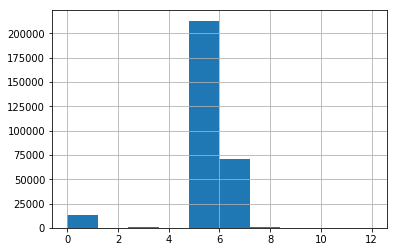

In [133]:
for_predict_df_prod['predict_random_forest_0.81_0.82_f1_0.81'].hist()

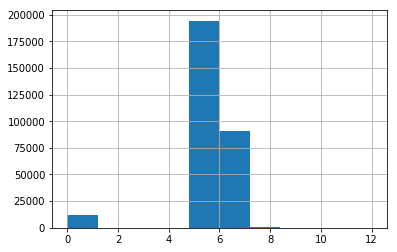

In [132]:
for_predict_df_prod['predict_cat_boost_7008'].hist()

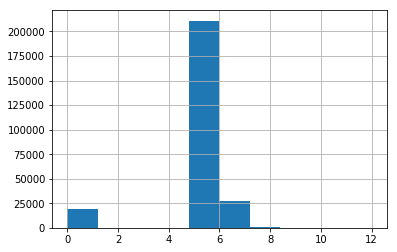

In [58]:
for_predict_df_prod['predict_random_forest_f1_0_80'].hist()

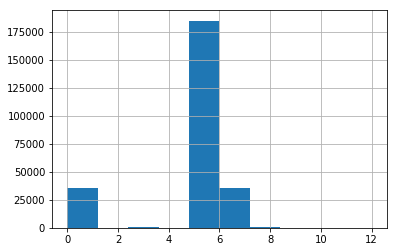

In [59]:
for_predict_df_prod['predict_catboost_f1_0_77'].hist()

In [143]:
rmse = mean_squared_error(for_predict_df_prod['predict_random_forest_f1_0_84'], for_predict_df_prod['predict_catboost_f1_0_77'])
print('rmse ' + str(rmse))

KeyError: 'predict_catboost_f1_0_77'

In [134]:
%load_ext autoreload
from feature_interval_extraction import get_interval_collector

def get_well_with_distance_features__(well):
    def add_feature_last(well_in, shift_last, name):
        well_in[name + '_last_' + str(shift_last / 5)] = well_in[name].shift(periods=-shift_last)

    def add_feature_next(well_in, shift_next, name):
        well_in[name + '_next_' + str(shift_next / 5)] = well_in[name].shift(periods=+shift_next)

    distance_meter = [3, 6, 9, 12, 15]
    distance_shift = [meter * 5 for meter in distance_meter]
    well_copy = well.copy()

    for shift in distance_shift:
        add_feature_last(well_copy, shift, 'GR')
        add_feature_last(well_copy, shift, 'SP')
        add_feature_last(well_copy, shift, 'BK')
        add_feature_last(well_copy, shift, 'NKTB')

        add_feature_next(well_copy, shift, 'GR')
        add_feature_next(well_copy, shift, 'SP')
        add_feature_next(well_copy, shift, 'BK')
        add_feature_next(well_copy, shift, 'NKTB')

    return well_copy


def get_df_interval_result(well, intervals):
    dfs_parts = []
    for interval in intervals:
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            df_part_min = well[well['MD'] >= min_]
            df_part = df_part_min[df_part_min['MD'] <= max_]
        else:
            df_part_min = well[well['MD'] <= min_]
            df_part = df_part_min[df_part_min['MD'] >= max_]
        dfs_parts.append(df_part)
    all = pd.concat(dfs_parts)
    return all.drop_duplicates()


def get_df_intervals_result(well, intervals):
    dfs_parts = []
    for interval in intervals:
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            df_part_min = well[well['MD'] >= min_]
            df_part = df_part_min[df_part_min['MD'] <= max_]
        else:
            df_part_min = well[well['MD'] <= min_]
            df_part = df_part_min[df_part_min['MD'] >= max_]
        dfs_parts.append(df_part)
    return dfs_parts


def get_df_middle_intervals_result(well, intervals):
    def get_left_md(interval):
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            return min_
        else:
            return max_

    def get_right_md(interval):
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            return max_
        else:
            return min_

    if len(intervals) == 0:
        return 0
    well_copy = well.copy()
    if len(intervals) == 1:
        left = get_left_md(intervals[0])
        right = get_right_md(intervals[0])
        left_df = well_copy[well_copy['MD'] < left]
        right_df = well_copy[well_copy['MD'] > right]
        return [left_df, right_df]

    middle_interval_dfs = []
    for index, interval in enumerate(intervals):
        if index == 0:
            left = get_left_md(intervals[index])
            left_df = well_copy[well_copy['MD'] < left]
            middle_interval_dfs.append(left_df)
            continue
        if index == len(intervals) - 1:
            right = get_right_md(intervals[index])
            right_df = well_copy[well_copy['MD'] > right]
            middle_interval_dfs.append(right_df)
            continue
        right_current = get_right_md(intervals[index])
        left_next = get_left_md(intervals[index + 1])
        df_part_right = well_copy[well_copy['MD'] > right_current]
        df_part = df_part_right[df_part_right['MD'] < left_next]
        if not df_part.empty:
            middle_interval_dfs.append(df_part)
    return middle_interval_dfs


def add_statistic_for_interval(middle_interval_dfs, feature_names, new_feature_prefix):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        for name in feature_names:
            part['max_' + new_feature_prefix + name] = part[name].max()
            part['min_' + new_feature_prefix + name] = part[name].min()
            if part[name].max() == part[name].min():
                part['std_' + new_feature_prefix + name] = 0
            else:
                part['std_' + new_feature_prefix + name] = part[name].std()
            part['mean_' + new_feature_prefix + name] = part[name].mean()
        results.append(part)
    return pd.concat(results)


def get_with_interval_feature_extraction(well, features_name_for_extraction,
                                         percent_change_border, new_feature_prefix, features_name_for_statistic):
    intervals = get_interval_collector(well, features_name_for_extraction, percent_change_border)
    interval_df = get_df_intervals_result(well, intervals)
    middle_interval_df = get_df_middle_intervals_result(well, intervals)
    with_statistic_middle = add_statistic_for_interval(middle_interval_df, features_name_for_statistic,
                                                       new_feature_prefix)
    with_statistic_intervals = add_statistic_for_interval(interval_df, features_name_for_statistic, new_feature_prefix)
    concat_df = pd.concat([with_statistic_middle, with_statistic_intervals])
    remove_duplicates = concat_df.drop_duplicates(subset='MD', keep="last")
    return remove_duplicates.sort_index()


def add_interval_column(middle_interval_dfs, new_column_name, feature_sp_gr):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['max_' + new_column_name] = part[feature_sp_gr].max()
        part['min_' + new_column_name] = part[feature_sp_gr].min()
        results.append(part)
    return pd.concat(results)


def add_interval_column_nulls(middle_interval_dfs, new_column_name):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['max_' + new_column_name] = -9999
        part['min_' + new_column_name] = -9999
        results.append(part)
    return pd.concat(results)


def get_column_with_interval(well, features_name_for_extraction,
                             percent_change_border, new_column_name, feature_sp_or_gr):
    intervals = get_interval_collector(well, features_name_for_extraction, percent_change_border)
    interval_df = get_df_intervals_result(well, intervals)
    middle_interval_df = get_df_middle_intervals_result(well, intervals)
    with_statistic_middle = add_interval_column_nulls(middle_interval_df, new_column_name)
    with_statistic_intervals = add_interval_column(interval_df, new_column_name, feature_sp_or_gr)
    concat_df = pd.concat([with_statistic_middle, with_statistic_intervals])
    remove_duplicates = concat_df.drop_duplicates(subset='MD', keep="last")
    return remove_duplicates.sort_index()


def get_well_with_features_df(wells, feature_names, percents_borders):
    wells_return = []
    wells_nulls = []
    index_well = 0
    for well in wells:
        well_copy = well.copy()
        well_copy = get_well_with_distance_features__(well_copy)
        wells_return.append(well_copy)

    print(len(wells_nulls))
    return wells_return


well_with_features = get_well_with_features_df(wells_add_detrends_df, ['SP'], [0.1])
for_ml_preprocessing = pd.concat(well_with_features)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0


In [137]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
def standarize_feature(train_df, cols, test_df=0):
    def save_simple_model(model, name):
        import pickle
        from sklearn.externals import joblib
        with open(name, 'wb') as f:
             pickle.dump(model, f)
            
    def load_simple_model(name):
        from sklearn.externals import joblib
        test_load_model = joblib.load(name)
        return test_load_model
    
    scaler = RobustScaler(quantile_range=(25.0, 75.0))
    for col in cols:
        train_df[col] = scaler.fit_transform(train_df[col].values.reshape(-1,1).astype(np.float32))
        #if type(test_df)!=int:
            #test_df[col] = scaler.transform(test_df[col].values.reshape(-1,1).astype(np.float32))
    save_simple_model(scaler, 'RobustScaler')
    return None

def get_well_with_features_df_rebost(wells):
    wells_return = []
    wells_nulls = []
    for well in wells:
        well_copy = well.copy().dropna()
        if not well_copy.empty:
            standarize_feature(well_copy, [i for i in well_copy.columns if i!= 'wellName' 
                                       and i!='datasetName'  
                                       and i!='MD'
                                       and i!='LAYER'
                                       and i!='LIT'
                                       and i!='Facies'])
            wells_return.append(well_copy)
    print(len(wells_nulls))
    return wells_return

well_with_features_ = get_well_with_features_df_rebost(well_with_features)
for_ml_preprocessing = pd.concat(well_with_features_)



def get_features_filtering(wells):
    well_copy = wells.copy()
    del well_copy['LAYER']
    del well_copy['datasetName']
    #del well_copy['BK']
    #del well_copy['NKTB']
    well_copy = well_copy[well_copy['Facies'] > -1]
    for name_feature in well_copy.columns:
        if name_feature != 'wellName' and name_feature != 'Facies':
            print(name_feature)
            well_copy = well_copy[well_copy[name_feature] > -999]
    return well_copy.dropna()

def get_for_learn_featres(for_all_feature_df):
    feature = for_all_feature_df.copy()
    del feature['Facies']
    del feature['wellName']
    del feature['LIT']
    del feature['MD']
    return feature


def get_for_learn_target_class(for_all_feature_df):
    target_class = for_all_feature_df.copy()
    target_class = target_class['Facies']#.apply(lambda x: float(x))
    return target_class


for_ml_with_features = get_features_filtering(for_ml_preprocessing)
display(for_ml_with_features.describe())

features = get_for_learn_featres(for_ml_with_features)
target_facies = get_for_learn_target_class(for_ml_with_features)
display(features)

0
MD
BK
GR
LIT
NKTB
SP
SP_detrend
GR_last_3.0
SP_last_3.0
BK_last_3.0
NKTB_last_3.0
GR_next_3.0
SP_next_3.0
BK_next_3.0
NKTB_next_3.0
GR_last_6.0
SP_last_6.0
BK_last_6.0
NKTB_last_6.0
GR_next_6.0
SP_next_6.0
BK_next_6.0
NKTB_next_6.0
GR_last_9.0
SP_last_9.0
BK_last_9.0
NKTB_last_9.0
GR_next_9.0
SP_next_9.0
BK_next_9.0
NKTB_next_9.0
GR_last_12.0
SP_last_12.0
BK_last_12.0
NKTB_last_12.0
GR_next_12.0
SP_next_12.0
BK_next_12.0
NKTB_next_12.0
GR_last_15.0
SP_last_15.0
BK_last_15.0
NKTB_last_15.0
GR_next_15.0
SP_next_15.0
BK_next_15.0
NKTB_next_15.0


MD            BK       Facies           GR          LIT  \
count  2407.000000   2407.000000  2407.000000  2407.000000  2407.000000   
mean   2616.836311   2109.883301     5.227669    -0.168792     2.272538   
std     135.646068   4082.559326     2.568694     0.737557     1.530137   
min    2507.600000     -0.934485     0.000000    -1.926641     1.000000   
25%    2551.000000      0.208689     5.000000    -0.763035     1.000000   
50%    2573.600000      0.999920     5.000000    -0.227842     1.000000   
75%    2603.000000      6.165843     7.000000     0.386310     4.000000   
max    3060.400000  10177.602539    12.000000     1.942326     5.000000   

              NKTB           SP   SP_detrend  GR_last_3.0  SP_last_3.0  ...  \
count  2407.000000  2407.000000  2407.000000  2407.000000  2407.000000  ...   
mean      0.966037    -0.131862    -0.542684    -0.134195    -0.105791  ...   
std       1.026344     0.440139     0.536828     0.747278     0.429767  ...   
min      -1.405964    -1.707471    -2.852888    -1.924783    -1.734725  ...   
25%       0.274376    -0.380624    -0.806790    -0.748140    -0.335583  ...   
50%       0.795872    -0.048851    -0.393469    -0.137404    -0.027430  ...   
75%       1.438776     0.174170    -0.173571     0.437883     0.183037  ...   
max       6.766817     0.861024     0.215628     1.935910     0.877302  ...   

       BK_next_12.0  NKTB_next_12.0  GR_last_15.0  SP_last_15.0  BK_last_15.0  \
count   2407.000000     2407.000000   2407.000000   2407.000000   2407.000000   
mean    2148.726562        0.534740     -0.080289     -0.036383   2109.113037   
std     4099.158203        1.264567      0.655496      0.382677   4082.252686   
min     -759.496277       -2.722891     -1.746695     -1.552517     -0.775904   
25%        0.545454       -0.265153     -0.550000     -0.257968      0.065217   
50%        3.170809        0.484536     -0.065952      0.011903      0.657143   
75%      134.329895        1.157572      0.439681      0.217194      2.762593   
max    11485.592773        6.725333      1.917916      0.917966  10123.256836   

       NKTB_last_15.0  GR_next_15.0  SP_next_15.0  BK_next_15.0  \
count     2407.000000   2407.000000   2407.000000   2407.000000   
mean         0.772520      4.873693     -0.016010   2162.942139   
std          0.942468      7.623682      0.477888   4110.545898   
min         -1.165177     -1.740476     -1.590093   -759.494446   
25%          0.164835     -0.341400     -0.257821      0.870296   
50%          0.635317      0.765326      0.086354      6.525582   
75%          1.186992     10.316683      0.245032    188.308334   
max          5.056912     31.917309      1.302923  11485.592773   

       NKTB_next_15.0  
count     2407.000000  
mean         0.368594  
std          1.341069  
min         -2.690477  
25%         -0.578362  
50%          0.333332  
75%          1.083125  
max          6.715325  

[8 rows x 48 columns]

BK        GR      NKTB        SP  SP_detrend  GR_last_3.0  \
5044    1.941177 -0.385343  1.538244 -0.418851   -1.059056    -1.004728   
5045    1.887701 -0.574468  1.980251 -0.422069   -1.062545    -1.087470   
5046    2.935829 -0.609929  2.182102 -0.434023   -1.074899    -1.113475   
5047    4.764706 -0.671395  2.220773 -0.380690   -1.020998    -1.108747   
5048    5.657754 -0.628842  2.207896 -0.277701   -0.916706    -1.073286   
5049    7.085562 -0.470449  2.240062 -0.244598   -0.883335    -0.990544   
5050    6.080214 -0.274232  2.019592 -0.177011   -0.814970    -0.945626   
5051    3.374332  0.141844  1.579160 -0.094713   -0.731674    -0.976359   
5052    1.925134  0.666667  1.077581 -0.057931   -0.694570    -1.037825   
5053    2.641712  0.725768  1.056153 -0.198621   -0.837568    -1.059102   
5054    2.893048  0.295508  1.469713 -0.343448   -0.984765    -1.002364   
5055    2.508022 -0.085106  1.647013 -0.414253   -1.056841    -0.848700   
5056    2.780749 -0.222222  1.741318 -0.512184   -1.156447    -0.631206   
5057    3.844920 -0.470449  1.834834 -0.537471   -1.182332    -0.340426   
5058    4.363636 -0.832151  1.934183 -0.559540   -1.204951    -0.104019   
5059    4.743316 -1.002364  2.104379 -0.607356   -1.253698     0.075650   
5060    5.208556 -1.085106  2.246483 -0.607816   -1.254388     0.328605   
5061    4.556150 -1.111111  2.123858 -0.605977   -1.252744     0.276596   
5062    4.048129 -1.106383  2.278544 -0.581149   -1.227772    -0.073286   
5063    3.438503 -1.070922  2.450209 -0.534713   -1.180869    -0.274232   
5064    2.598931 -0.988180  2.437575 -0.451954   -1.097107    -0.394799   
5065    2.737968 -0.943262  2.462828 -0.444598   -1.089865    -0.574468   
5066    3.310161 -0.973995  2.342410 -0.455632   -1.101285    -0.789598   
5067    4.090909 -1.035461  2.252901 -0.369195   -1.013790    -1.040189   
5068    4.358289 -1.056738  2.058802 -0.289195   -0.932828    -1.276596   
5069    8.368984 -1.000000  1.761421 -0.223908   -0.866795    -1.399527   
5070    5.192514 -0.846336  1.455954 -0.191265   -0.833891    -1.340425   
5071    2.379679 -0.628842  1.106082 -0.118161   -0.759927    -1.238770   
5072    1.417112 -0.338062  0.669890  0.002299   -0.637904    -1.269503   
5073    2.673797 -0.101655  0.150533  0.104368   -0.534545    -1.321513   
...          ...       ...       ...       ...         ...          ...   
124790 -0.261699 -0.374660  0.586010 -0.504886   -0.927426    -0.440444   
124791 -0.494241 -0.082956  0.628441 -0.493695   -0.914817    -0.334239   
124792 -0.539237  0.039891  0.712156 -0.455161   -0.870814    -0.324728   
124793 -0.573434  0.281732  0.377867 -0.428941   -0.840949    -0.353714   
124794 -0.488481  0.779918  0.831423 -0.420530   -0.831531    -0.352808   
124795 -0.076674  0.728921  0.934060 -0.551671   -0.982338    -0.296649   
124796  0.348452  0.245693  1.026950 -0.758586   -1.220144     0.038044   
124797  0.275018 -0.209429  0.955849 -0.916259   -1.401413     0.293478   
124798 -0.003960 -0.453309  0.934060 -0.992075   -1.488700     0.424366   
124799  0.268898 -0.683364  0.482225 -0.911232   -1.396122     0.200634   
124800  0.798056 -0.898232  1.115252 -0.773284   -1.237977    -0.016757   
124801  1.173866 -0.985041  1.555621 -0.639447   -1.084553     0.104846   
124802  0.828294 -0.740707  1.483946 -0.586246   -1.023710     0.341485   
124803  0.210583 -0.495920  0.981079 -0.630197   -1.074411     0.439538   
124804 -0.225342 -0.516546  0.706422 -0.732702   -1.192341     0.350090   
124805 -0.041397 -0.432684  0.616400 -0.822578   -1.295769     0.357110   
124806 -0.056516 -0.326383  0.583716 -0.914349   -1.401375     0.540761   
124807 -0.143629 -0.316863  0.845184 -0.936336   -1.426858     0.570879   
124808 -0.421166 -0.345875  0.724197 -0.881731   -1.364404     0.103034   
124809 -0.438445 -0.344968  0.647936 -0.764030   -1.229505    -0.114810   
124810 -0.582074 -0.288758  0.294152 -0.610623   -1.053613    -0.040082   
124811 -0.465803  0.046238  0.673739 -0

In [138]:
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import RFE

def p_cross_val(model, train, labels):
    from sklearn.model_selection import StratifiedKFold

    print('cross_val_predict')
    skf = StratifiedKFold(n_splits=10)
    predicted = cross_val_predict(model, train, labels, cv=skf)
    print(classification_report(labels, predicted))
    rmse = mean_squared_error(labels, predicted)
    print('rmse ' + str(rmse))

    scores = cross_val_score(model, train, labels, cv=skf)
    print("---cross_val_score---")
    print("CV scores: {0}".format(scores))
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


def get_optimization_params(train, labels, rfe_count):
    ridge_model_cv = get_best_model_ml(train, labels, rfe_count)
    rmse = get_oprimization(ridge_model_cv, train, labels)
    return rmse


def get_oprimization(model, train, labels):
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=9)
    predicted = cross_val_predict(model, train, labels, cv=skf)
    rmse = mean_squared_error(labels, predicted)
    return rmse


def get_best_model_ml(train, labels, rfe_count):
    model = RidgeClassifier(random_state=18, normalize=True)
    # train_data = Pool(train,  labels)

    # model = CatBoostClassifier(iterations=10,logging_level='Silent',class_weights=[0.9, 2])
    rfe = RFE(estimator=model, n_features_to_select=rfe_count)
    rfe = rfe.fit(train, labels)
    return rfe


def print_cross_val_predict(train, labels, rfe_count):
    ridge_model_cv = get_best_model_ml(train, labels, rfe_count)
    p_cross_val(ridge_model_cv, train, labels)
    print(ridge_model_cv.support_)
    print(sorted(zip(map(lambda x: round(x, 4), ridge_model_cv.ranking_), train.columns)))


def start_optimizer(train, labels):
    step_md = 4
    max_count = 250
    rmse_min = 50
    for rfe_count in range(50, max_count, step_md):
        rmse = get_optimization_params(train, labels, rfe_count)
        if rmse < rmse_min:
            rmse_min = rmse
            print('Rmse ' + str(rmse_min) + ' rfe_count ' + str(rfe_count))
            print_cross_val_predict(train, labels, rfe_count)

start_optimizer(features, target_facies)


Rmse 6.388034898213544 rfe_count 50
cross_val_predict


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.75      0.01      0.03       233
           1       1.00      0.56      0.72        86
           3       0.00      0.00      0.00        85
           5       0.64      0.88      0.74      1207
           7       0.55      0.63      0.59       581
           8       0.89      0.22      0.35       110
          12       0.00      0.00      0.00       105

   micro avg       0.63      0.63      0.63      2407
   macro avg       0.55      0.33      0.35      2407
weighted avg       0.60      0.63      0.56      2407

rmse 6.371832156211051
---cross_val_score---
CV scores: [0.77459016 0.67489712 0.781893   0.59090909 0.40909091 0.74166667
 0.45606695 0.74369748 0.56722689 0.5210084 ]
Accuracy: 0.63 (+/- 0.26)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  

In [139]:
def p_cross_val(model, train, labels):
    from sklearn.model_selection import StratifiedKFold

    print('cross_val_predict')
    skf = StratifiedKFold(n_splits=9)
    predicted = cross_val_predict(model, train, labels, cv=skf)
    print(classification_report(labels, predicted))
    rmse = mean_squared_error(labels, predicted)
    print('rmse ' + str(rmse))
    
def get_OneVsRestClassifier_randomForestRegressor(train, labels):
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
    
    reg = RandomForestClassifier(random_state = 18, bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, verbose=0, warm_start=False)

    OVR = OneVsRestClassifier(reg,n_jobs=-1)
    OVR.fit(train, labels)
    
    p(labels, OVR.predict(train).round())
    p_cross_val(OVR, train, labels)
    return OVR

prod_OneVsRest_RandomForest_model = get_OneVsRestClassifier_randomForestRegressor(features, target_facies) 

RMSE ошибка равна 0.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       233
           1       1.00      1.00      1.00        86
           3       1.00      1.00      1.00        85
           5       1.00      1.00      1.00      1207
           7       1.00      1.00      1.00       581
           8       1.00      1.00      1.00       110
          12       1.00      1.00      1.00       105

   micro avg       1.00      1.00      1.00      2407
   macro avg       1.00      1.00      1.00      2407
weighted avg       1.00      1.00      1.00      2407

cross_val_predict
              precision    recall  f1-score   support

           0       0.77      0.39      0.51       233
           1       0.70      0.73      0.72        86
           3       0.97      0.78      0.86        85
           5       0.76      0.89      0.82      1207
           7       0.65      0.61      0.63       581
           8       0.68      0.76     

In [ ]:
copy prod =  